In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from jcm.model import SpeedyModel, read_boundary_data
from jcm.params import Parameters

def make_ones_dinosaur_State_object(state, choose_sim_time = jnp.float32(1.0)):
    return jtu.tree_map(lambda x: jnp.ones_like(x), state)

def make_zeros_dinosaur_State_object(state, choose_sim_time = jnp.float32(0.0)):
    zero_state = jtu.tree_map(lambda x: jnp.zeros_like(x), state)
    # zero_state.temperature_variation = zero_state.temperature_variation.at[-1, 10:25, 10:25].set(1.0)
    # zero_state.temperature_variation = zero_state.temperature_variation.at[-1, 15:20, 15:20].add(1.0)
    return zero_state
    
def make_zeros_parameters_object(params):
    def make_tangent(x):
        if jnp.issubdtype(jnp.result_type(x), jnp.bool_):
            return np.zeros((), dtype=jax.dtypes.float0)
        elif jnp.issubdtype(jnp.result_type(x), jnp.integer):
            return np.zeros((), dtype=jax.dtypes.float0)
        else:
            return jnp.zeros_like(x)
    return jtu.tree_map(lambda x: make_tangent(x), params)

def make_ones_prediction_object(predictions):
    return jtu.tree_map(lambda x: jnp.ones_like(x), predictions)

def make_zeros_prediction_object(predictions):
    return jtu.tree_map(lambda x: jnp.zeros_like(x), predictions)

jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", False) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan

create_model = lambda boundary_data=read_boundary_data(): SpeedyModel(
    time_step=30,
    save_interval=12/24.,
    total_time=4.,
    layers=8,
    boundary_data=boundary_data,
    parameters=Parameters.default(),
    post_process=True
)

def model_run_wrapper(tsea):
    boundary_data = read_boundary_data().copy(tsea=tsea)
    model = create_model(boundary_data)
    state = model.get_initial_state()
    final_state, predictions = model.unroll(state)
    return predictions

# vjp

In [2]:
# tsea = read_boundary_data().tsea
# primal, vjp_fn = jax.vjp(model_run_wrapper, tsea)

In [3]:
# def create_cotangent(primal):
#     cotangent = jtu.tree_map(lambda x: jnp.zeros_like(x), primal)
#     # cotangent['physics'].shortwave_rad.ftop = jtu.tree_map(lambda x: jnp.ones_like(x), cotangent['physics'].shortwave_rad.ftop)
    
#     coords = create_model().coords
#     nodal_ones = jnp.ones_like(coords.horizontal.to_nodal(primal.temperature_variation))
#     cotangent.temperature_variation = cotangent.temperature_variation.at[-1].add(coords.horizontal.to_modal(nodal_ones)[-1])
#     return cotangent
# grad = vjp_fn(create_cotangent(primal))

In [4]:
# from pprint import pprint

# def to_readable_format(x):
#     if isinstance(x, jnp.ndarray):
#         return x.tolist()
#     return x

# pprint(jax.tree_util.tree_map(to_readable_format, grad))

# jvp

In [6]:
tsea = read_boundary_data().tsea

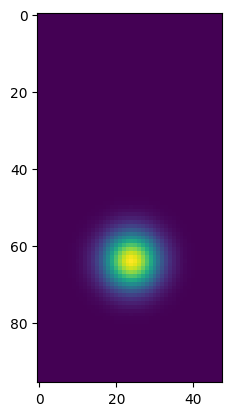

In [8]:
def localized_gaussian(m, n, i, j, sigma_i, sigma_j):
    """
    Generate a 2D Gaussian on an m x n grid centered at (i, j) with standard deviations sigma_i and sigma_j.
    """
    x = np.arange(n)
    y = np.arange(m)
    X, Y = np.meshgrid(x, y)
    
    gaussian = jnp.exp(-(((X - i) ** 2) / (2 * sigma_i ** 2) + ((Y - j) ** 2) / (2 * sigma_j ** 2)))
    return gaussian

# Example usage
m, n = tsea.shape
i, j = 2 * n // 4, 2 * m // 3    # Center of the Gaussian
sigma_i, sigma_j = 5, 5  # Standard deviations
g = localized_gaussian(m, n, i, j, sigma_i, sigma_j)

import matplotlib.pyplot as plt

plt.imshow(g)

tangent = g

In [9]:
y, jvp_at_x = jax.jvp(model_run_wrapper, (tsea,), (tangent,))

In [10]:
grad_ds = create_model().predictions_to_xarray(jvp_at_x)
print(f"dataset size: {grad_ds.nbytes/1e6:.1f}MB")

dataset size: 31.6MB


In [12]:
print(list(grad_ds.variables))

['mod_radcon.tau2.3', 'surface_flux.vstr.2', 'shortwave_rad.fsol', 'mod_radcon.albsfc', 'mod_radcon.st4a.1', 'convection.cbmf', 'surface_flux.vstr.0', 'surface_flux.rlds', 'surface_flux.shf.2', 'mod_radcon.tau2.2', 'surface_flux.ustr.0', 'surface_flux.evap.2', 'shortwave_rad.icltop', 'shortwave_rad.stratz', 'surface_flux.rlus.2', 'surface_flux.t0', 'mod_radcon.flux.1', 'land_model.stl_am', 'surface_flux.shf.1', 'shortwave_rad.rsns', 'mod_radcon.alb_l', 'shortwave_rad.zenit', 'shortwave_rad.rsds', 'shortwave_rad.ozupp', 'shortwave_rad.cloudc', 'mod_radcon.tau2.0', 'surface_flux.hfluxn.1', 'condensation.precls', 'shortwave_rad.ozone', 'mod_radcon.stratc.1', 'surface_flux.v0', 'surface_flux.tsfc', 'mod_radcon.alb_s', 'surface_flux.vstr.1', 'longwave_rad.dfabs', 'surface_flux.rlns', 'longwave_rad.ftop', 'humidity.rh', 'date.model_year', 'shortwave_rad.gse', 'u_dot_grad_log_sp', 'surface_flux.rlus.0', 'surface_flux.u0', 'convection.psa', 'humidity.qsat', 'mod_radcon.tau2.1', 'mod_radcon.flu

In [13]:
grad_ds.time

<xarray.DataArray 'time' (time: 8)> Size: 64B
array(['2000-01-01T00:00:00.000000000', '2000-01-01T12:00:00.000000000',
       '2000-01-02T00:00:00.000000000', '2000-01-02T12:00:00.000000000',
       '2000-01-03T00:00:00.000000000', '2000-01-03T12:00:00.000000000',
       '2000-01-04T00:00:00.000000000', '2000-01-04T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 64B 2000-01-01 ... 2000-01-04T12:00:00

gradient of mod_radcon.tau2.3 is -0.0
gradient of shortwave_rad.fsol is 0.0
gradient of mod_radcon.albsfc is 0.0
gradient of mod_radcon.st4a.1 is 0.0
gradient of convection.cbmf is 0.0
gradient of mod_radcon.tau2.2 is -0.0
gradient of shortwave_rad.stratz is 0.0
gradient of land_model.stl_am is 0.0
gradient of mod_radcon.alb_l is 0.0
gradient of shortwave_rad.zenit is 0.0
gradient of shortwave_rad.ozupp is 0.0
gradient of condensation.precls is 0.0
gradient of shortwave_rad.ozone is 0.0
gradient of mod_radcon.alb_s is 0.0


/home/jvm/miniconda3/envs/jax-dev-cuda/lib/python3.11/site-packages/xarray/plot/facetgrid.py:219: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


gradient of land_model.stl_lm is 0.0
gradient of condensation.dtlsc is 0.0
gradient of mod_radcon.snowc is 0.0
gradient of convection.precnv is 0.0
gradient of condensation.dqlsc is 0.0


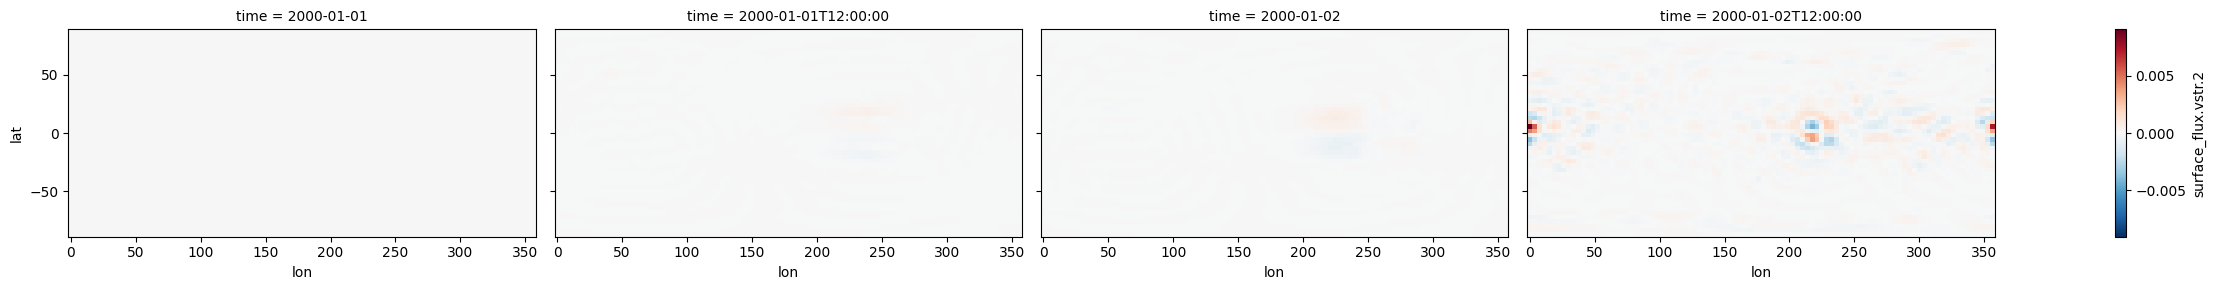

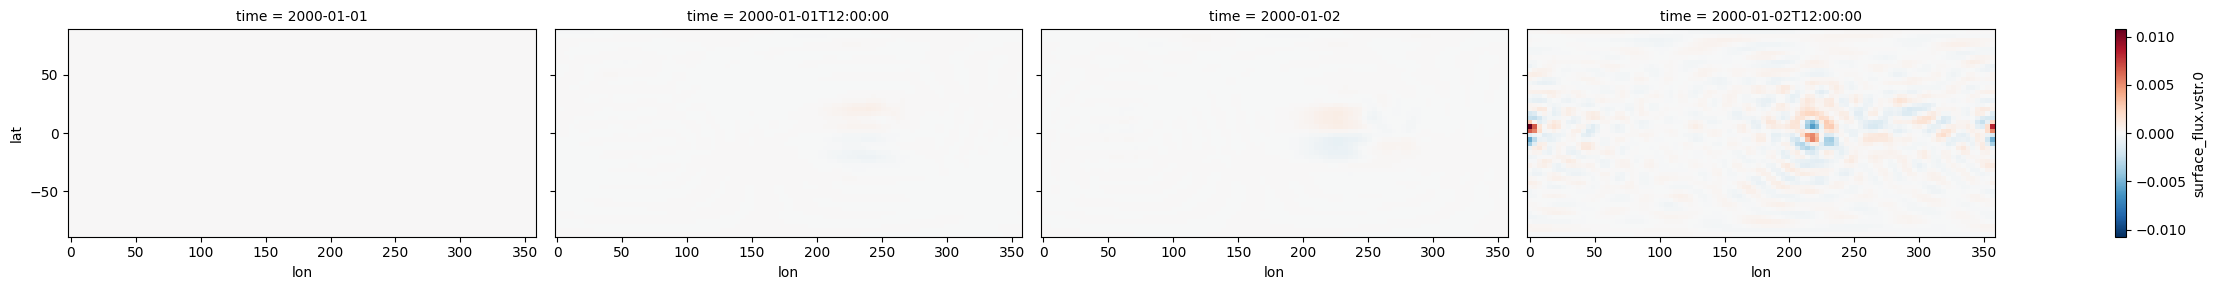

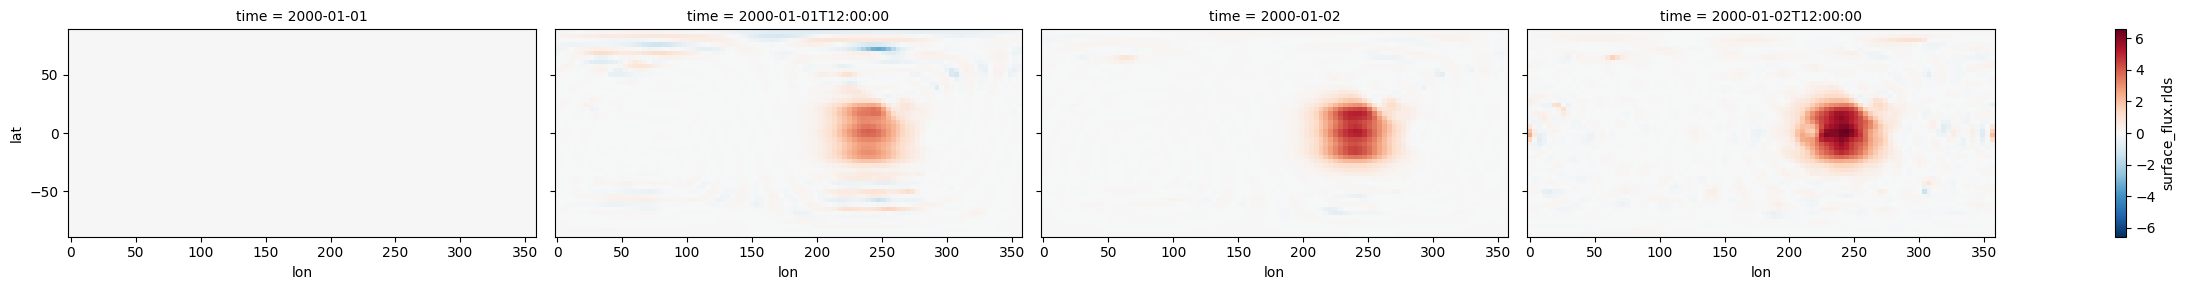

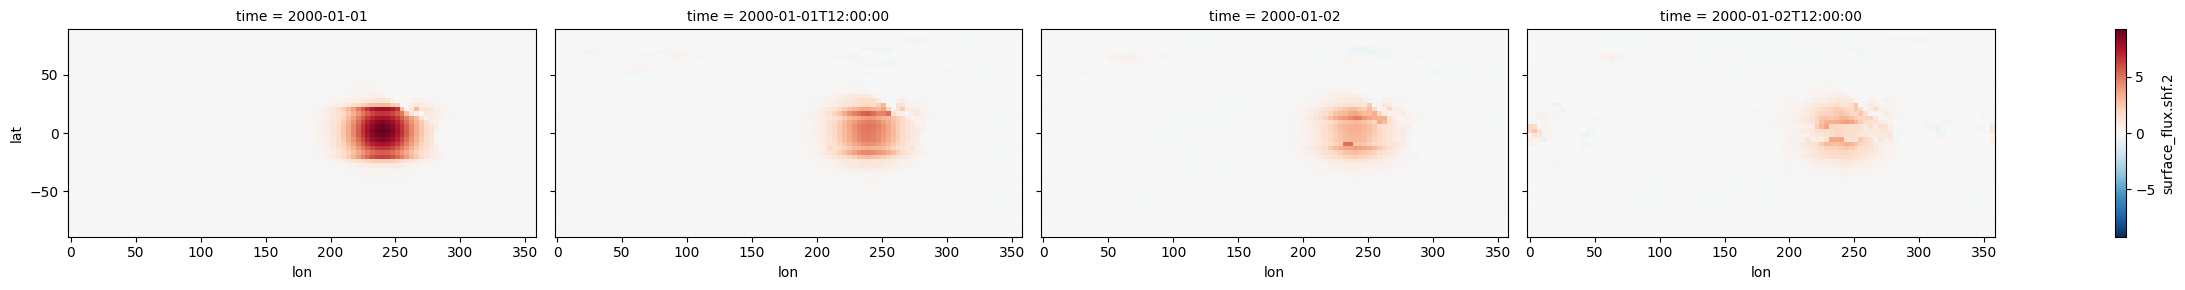

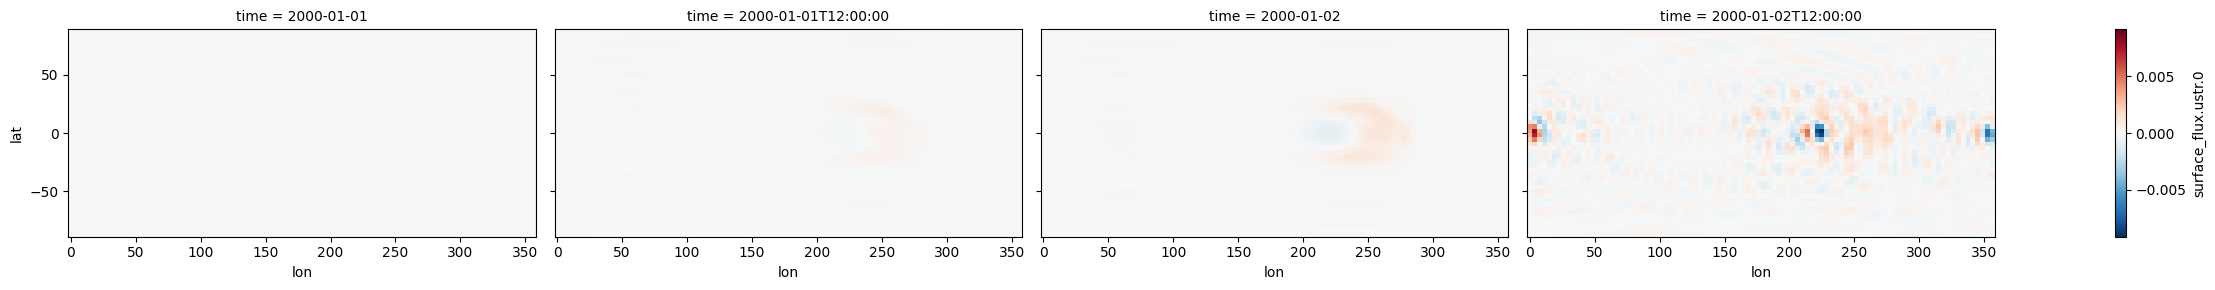

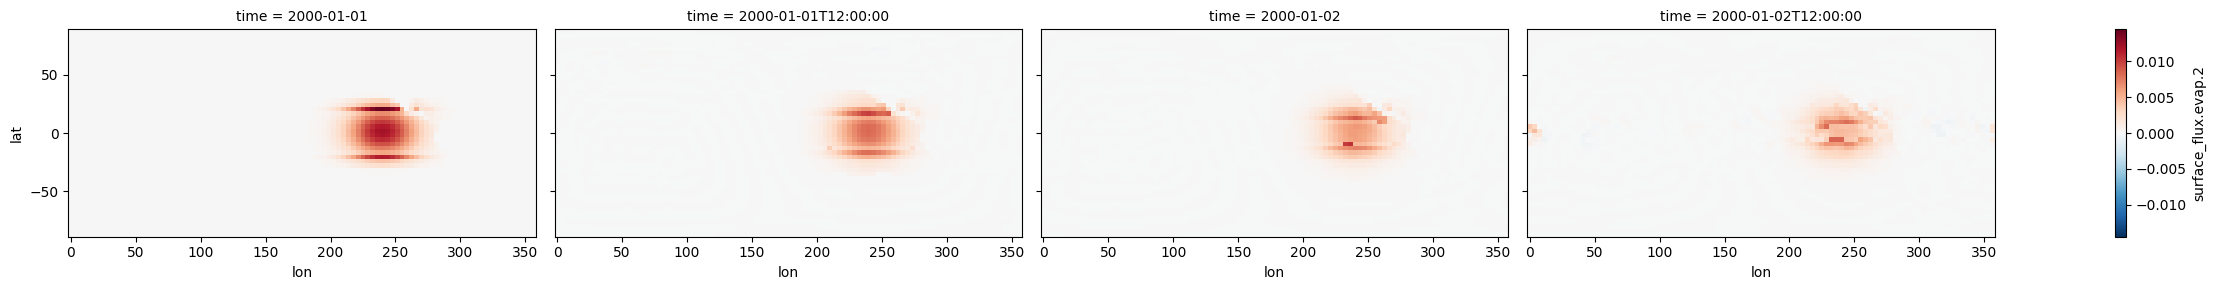

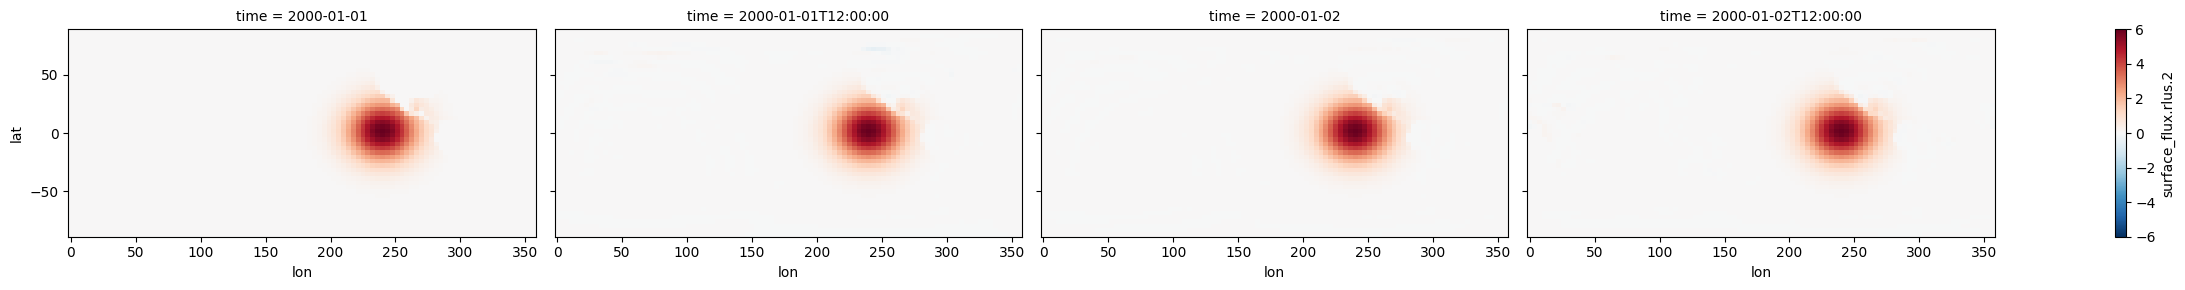

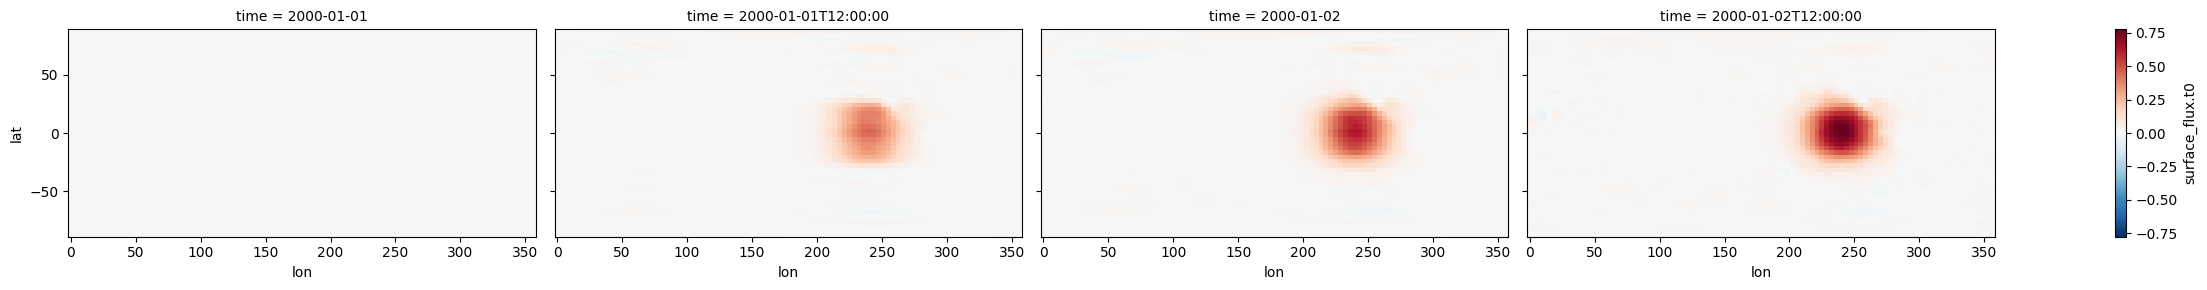

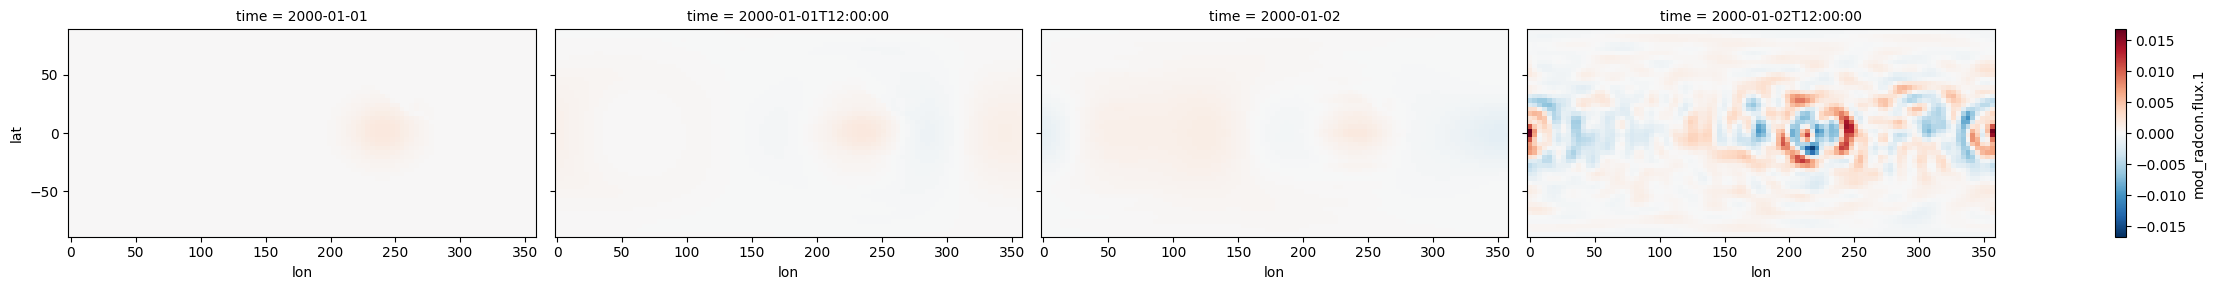

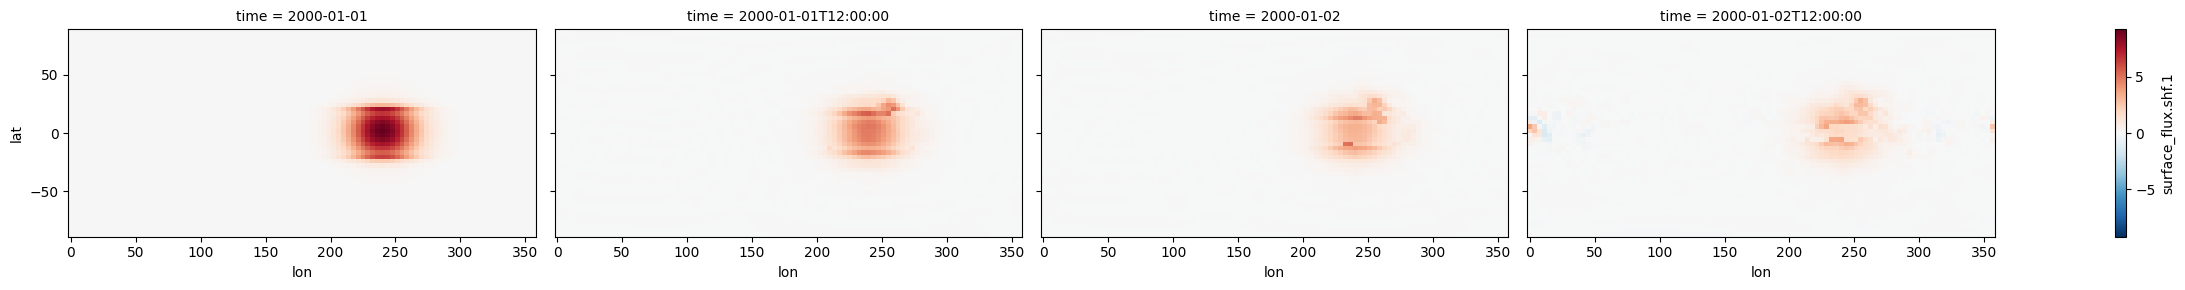

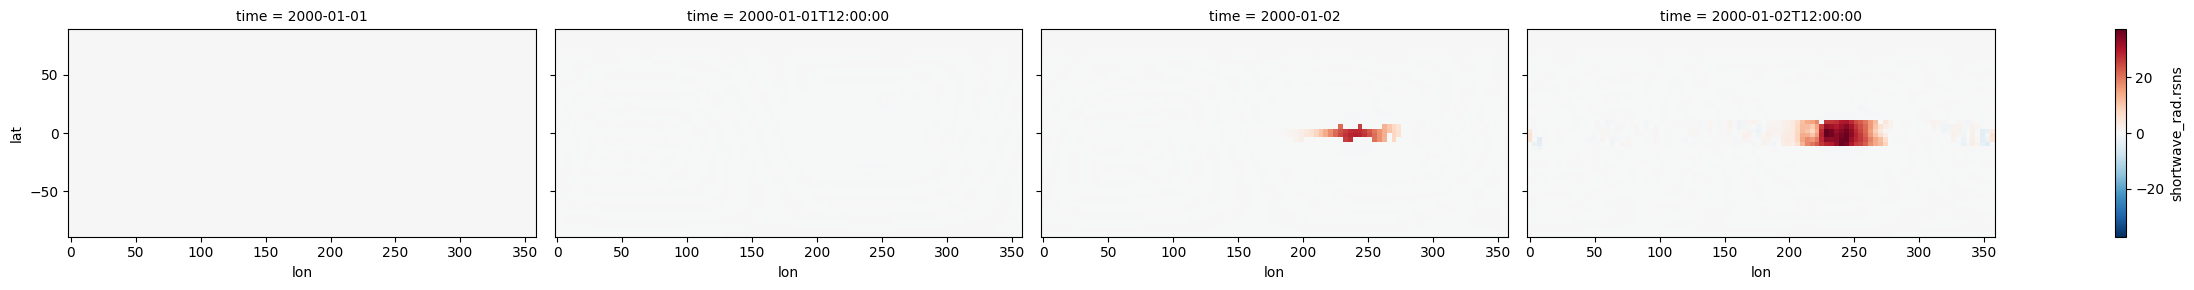

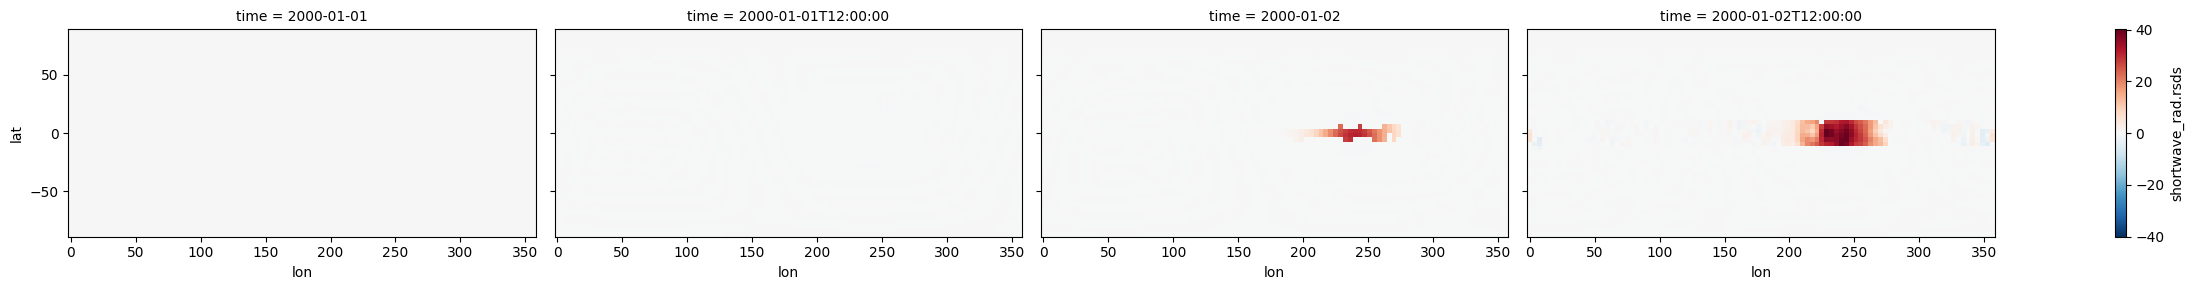

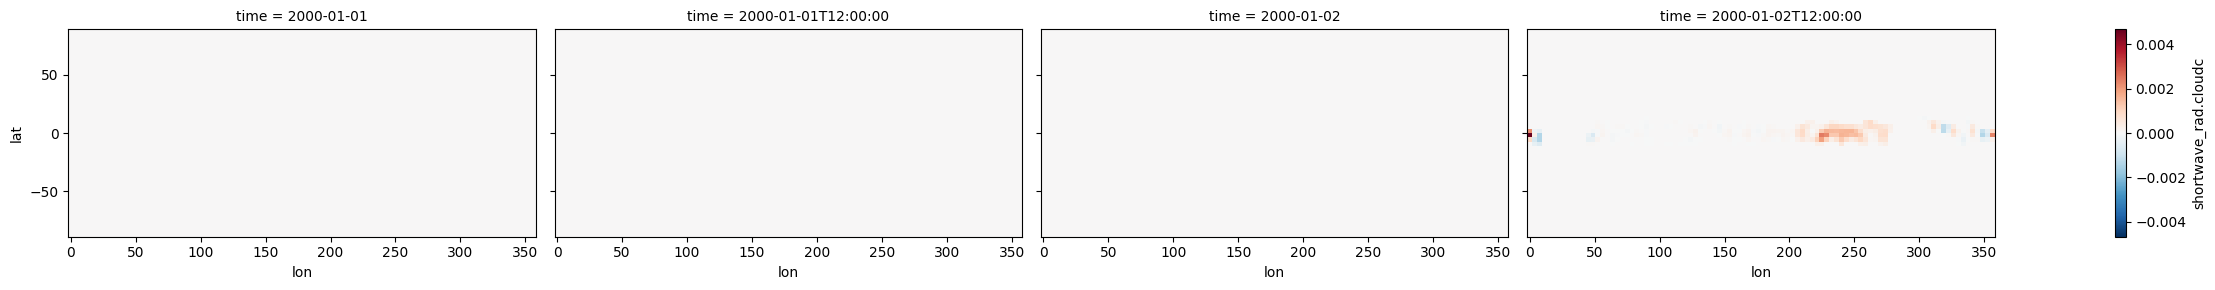

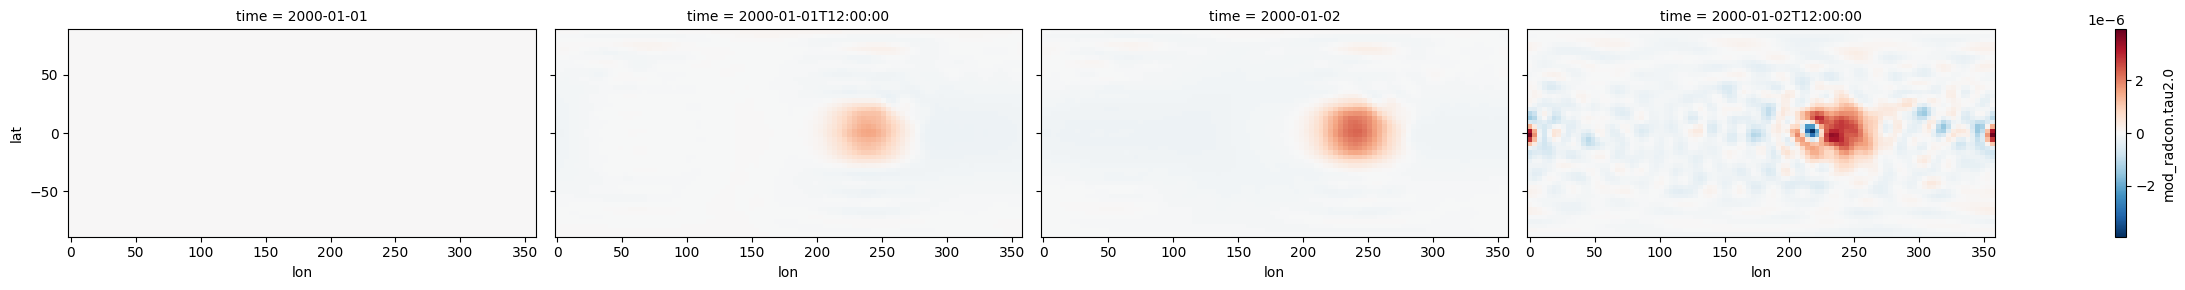

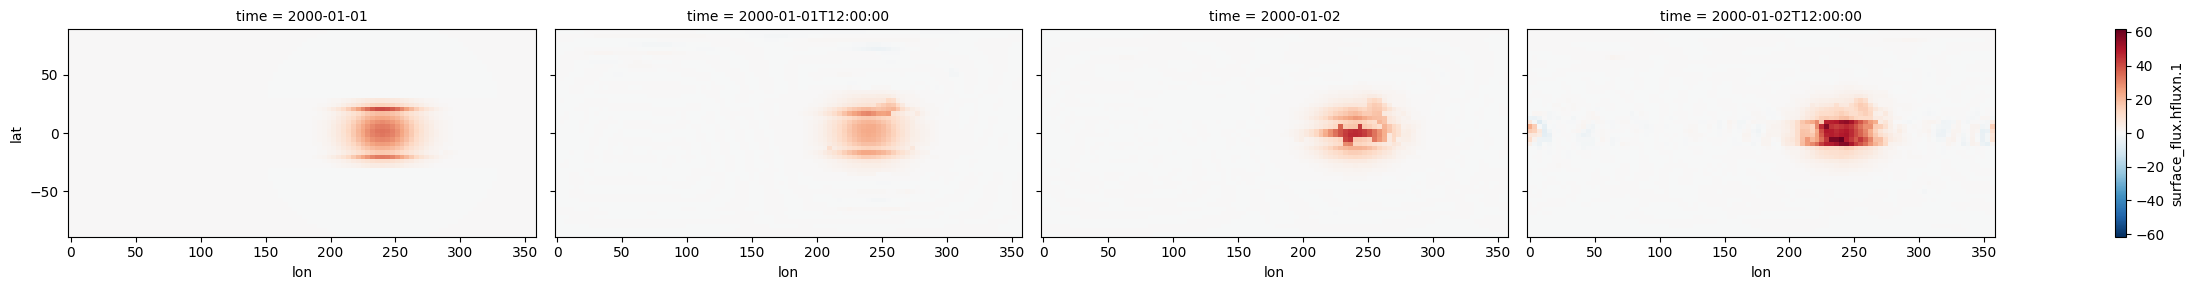

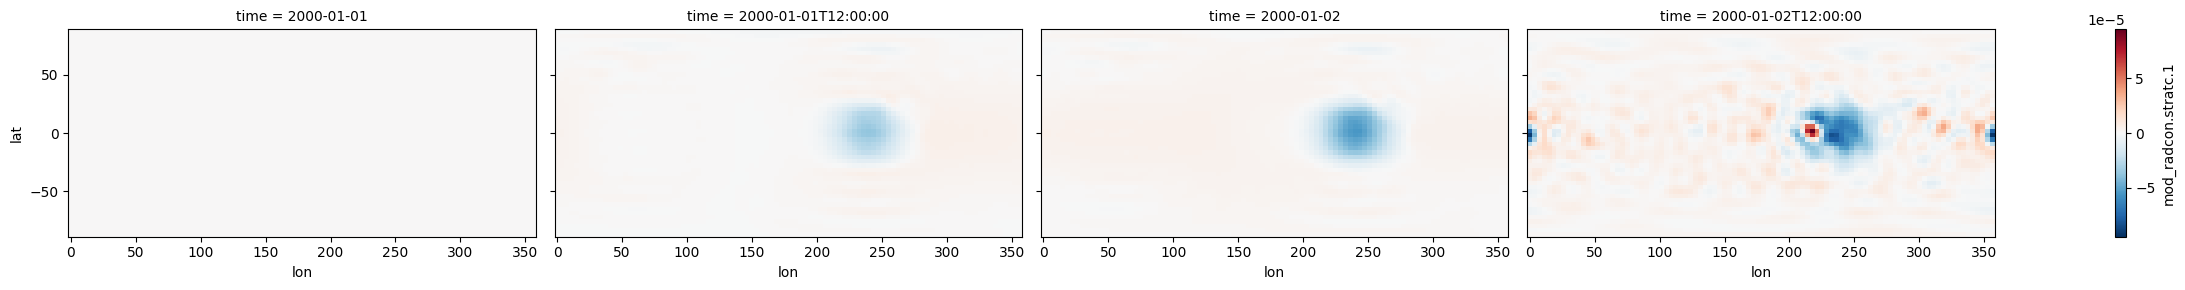

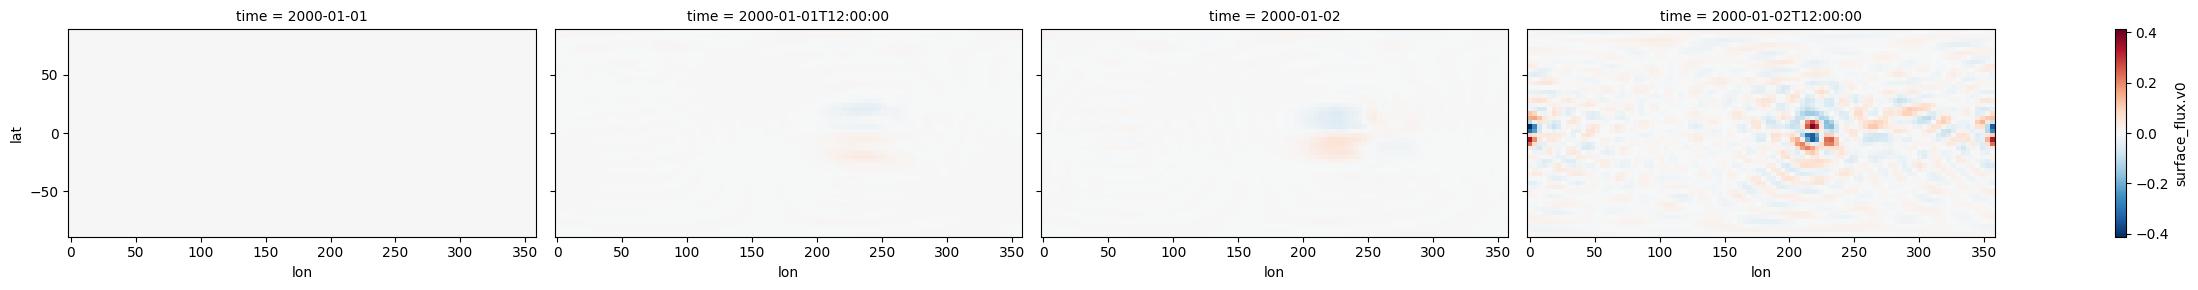

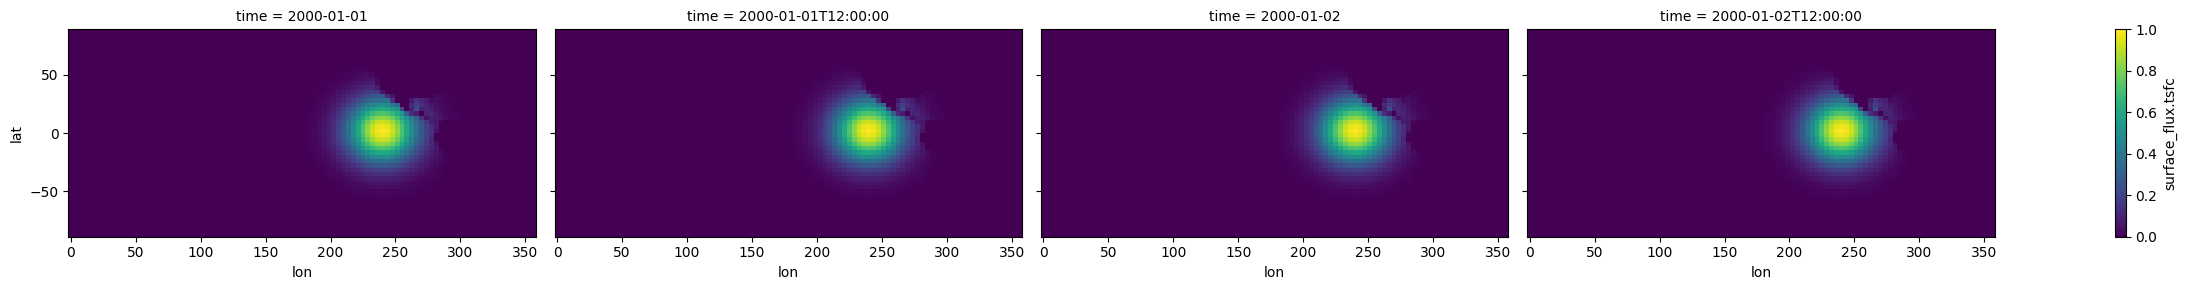

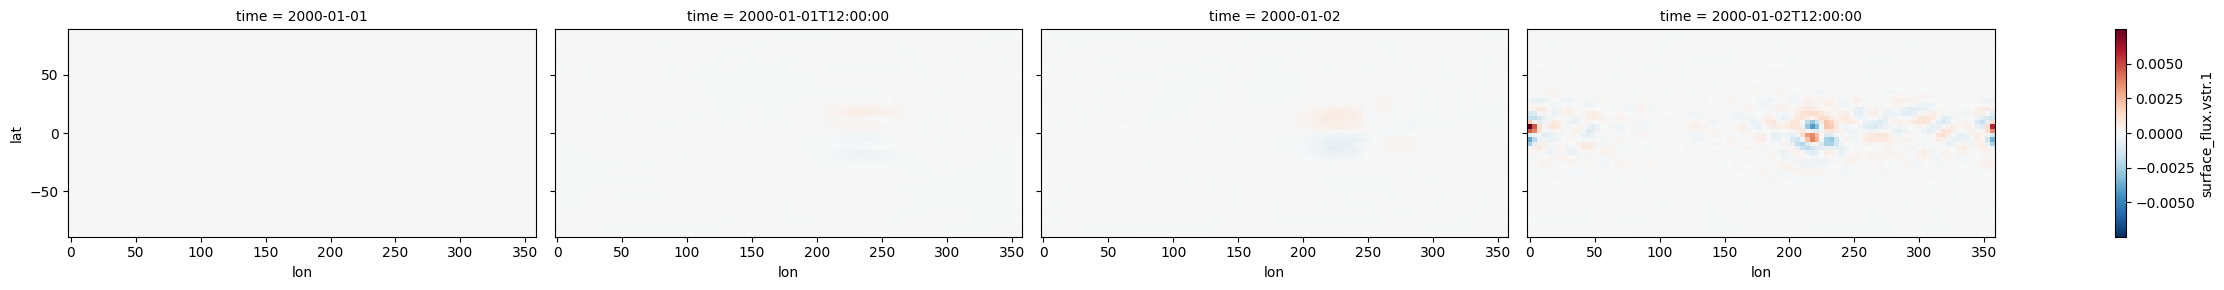

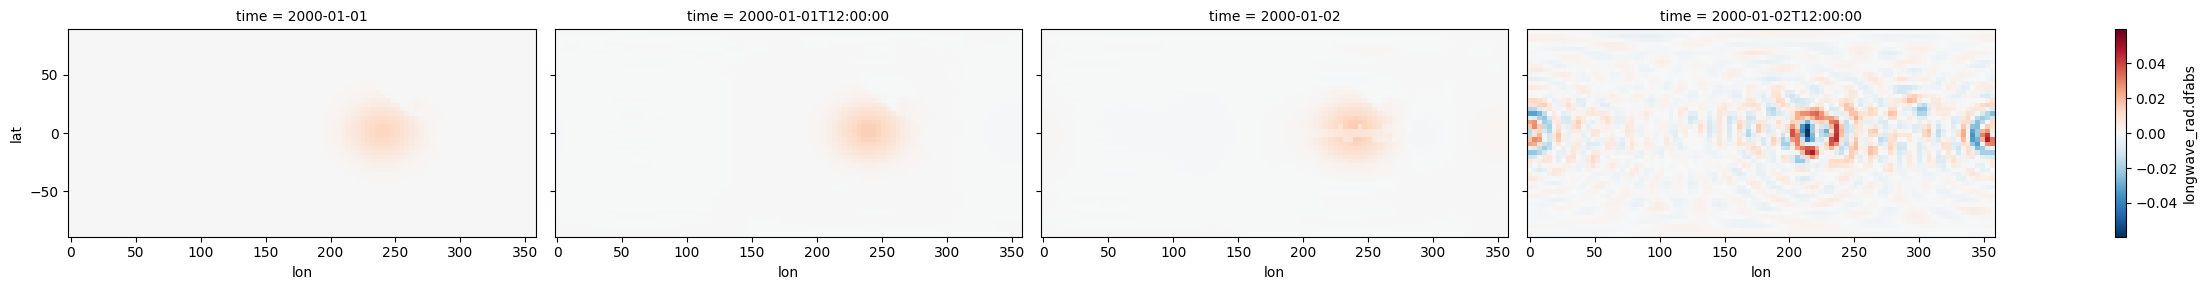

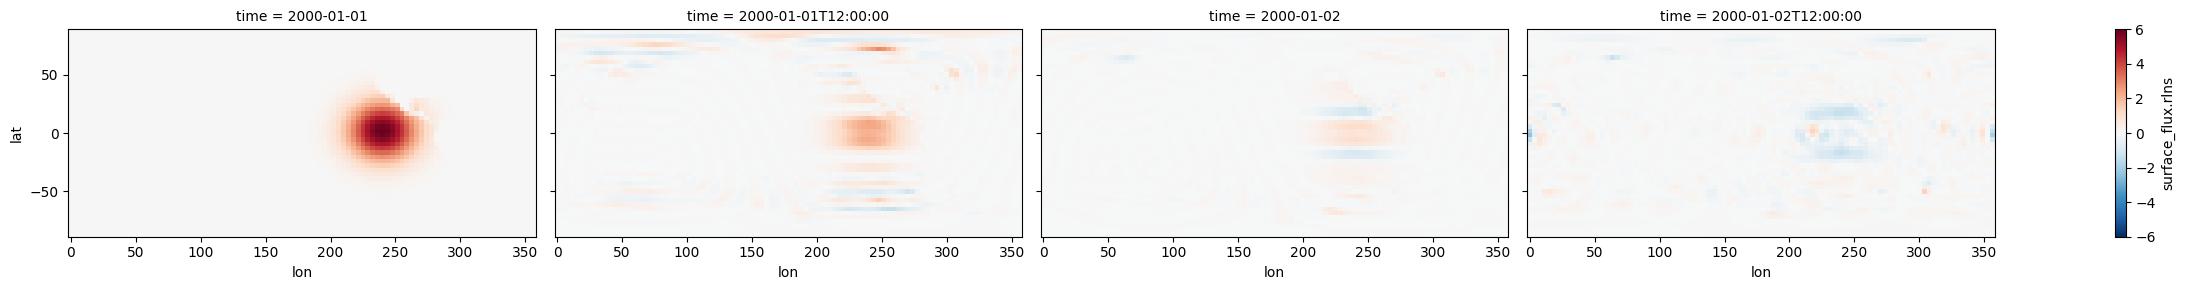

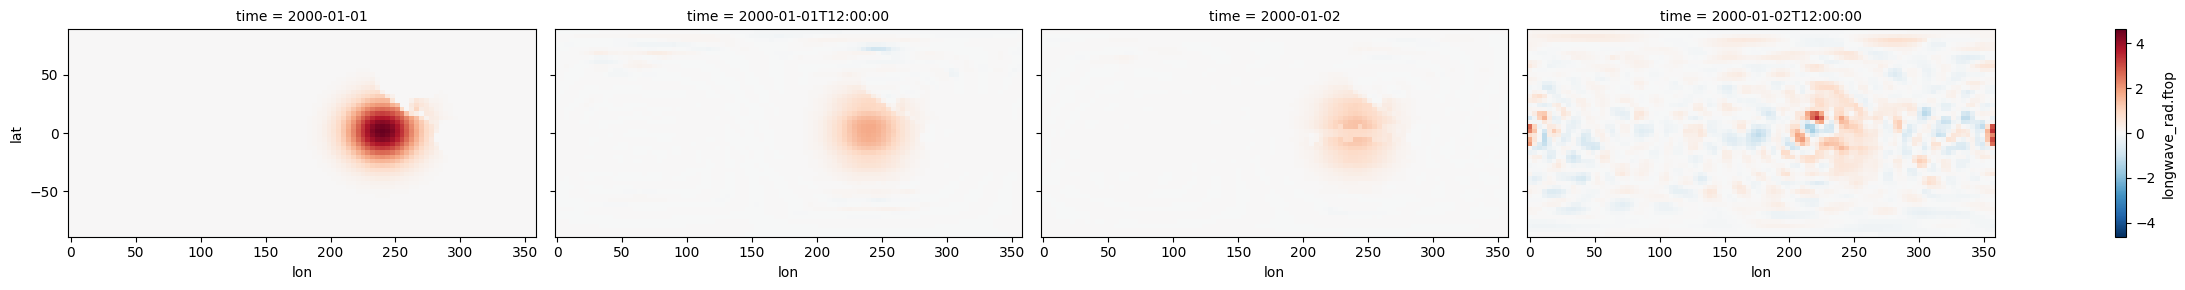

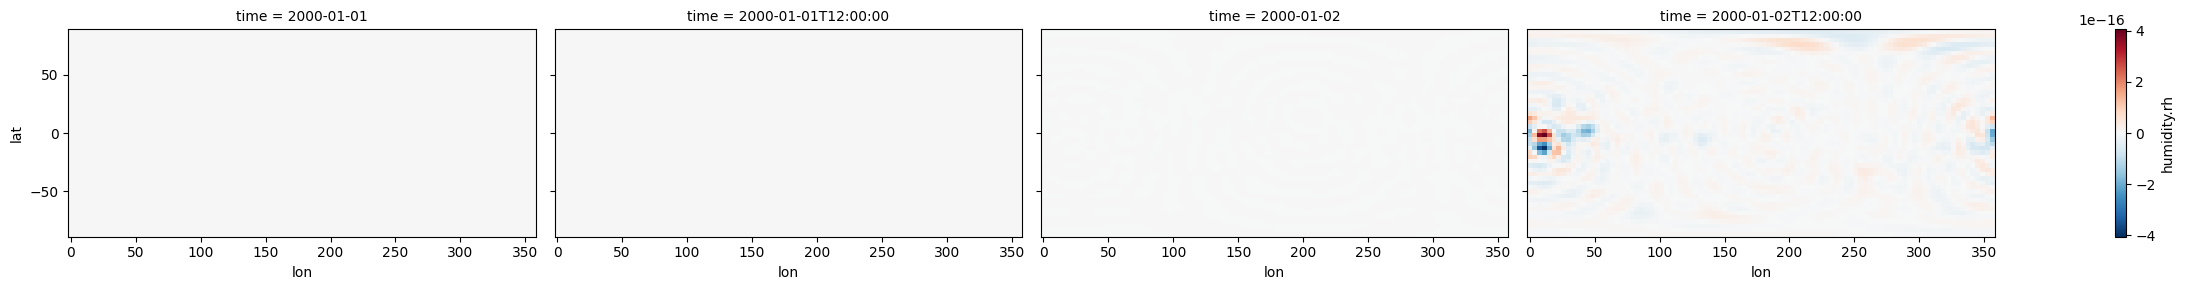

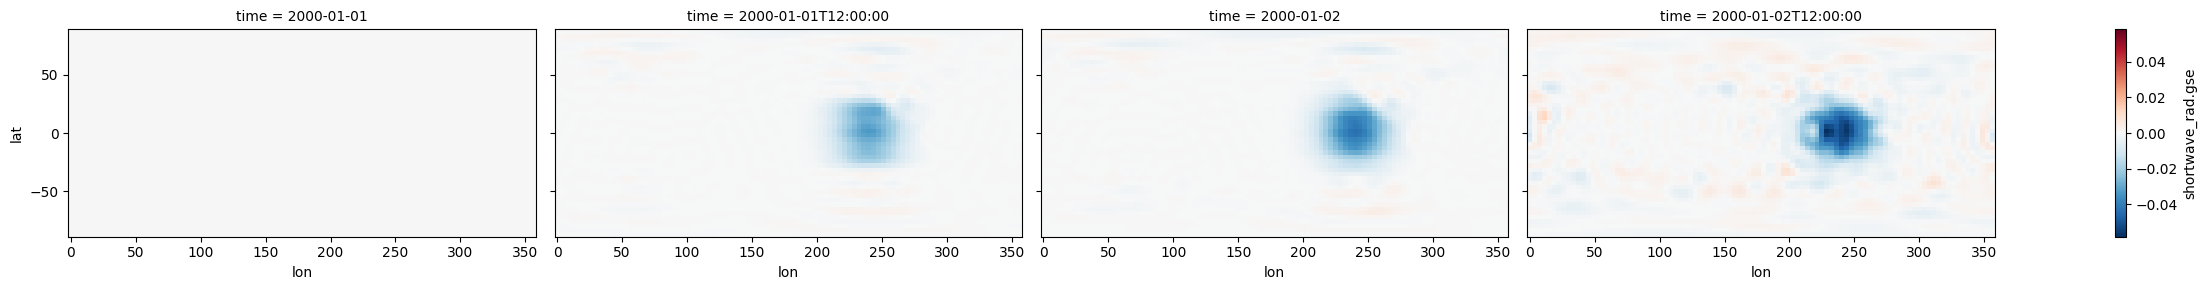

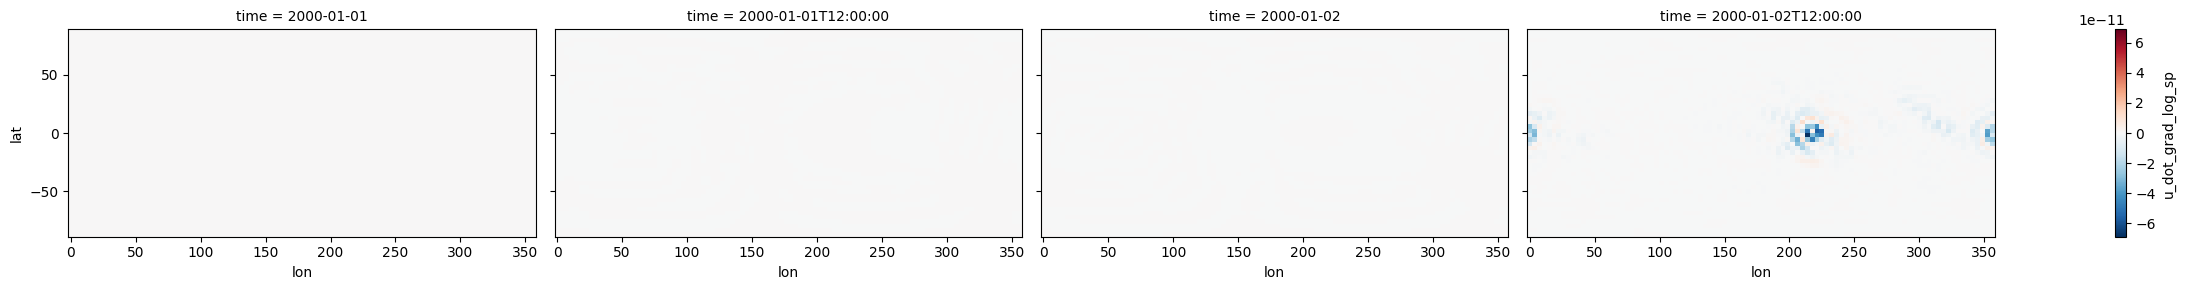

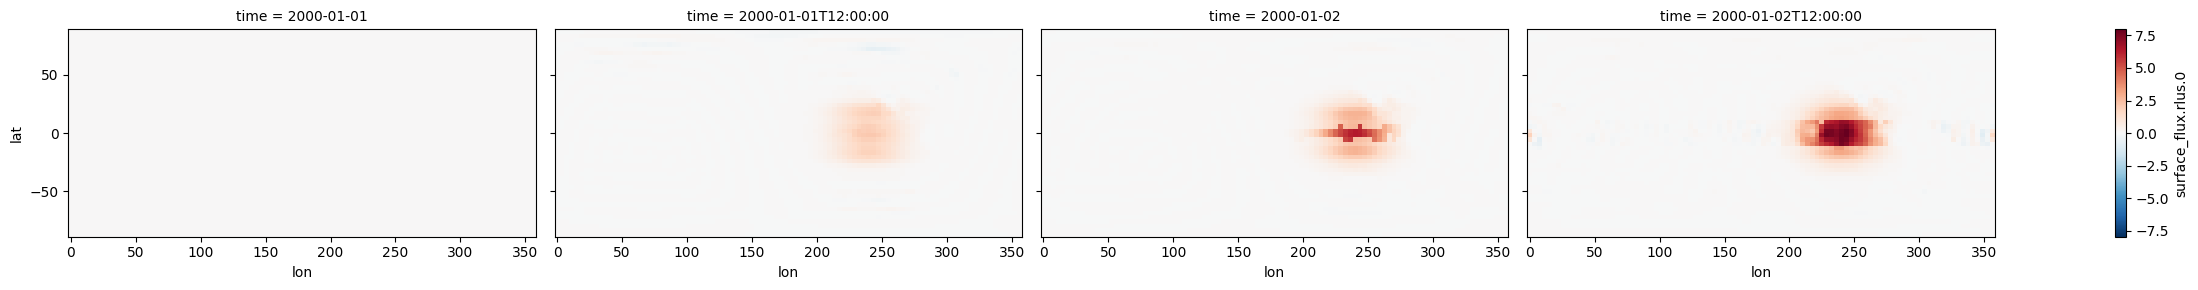

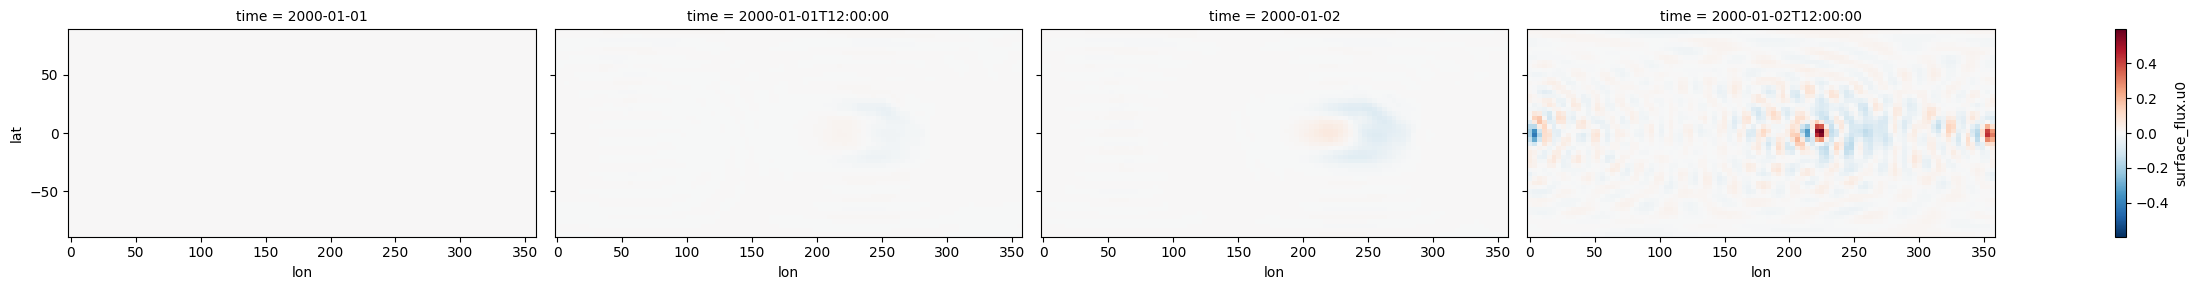

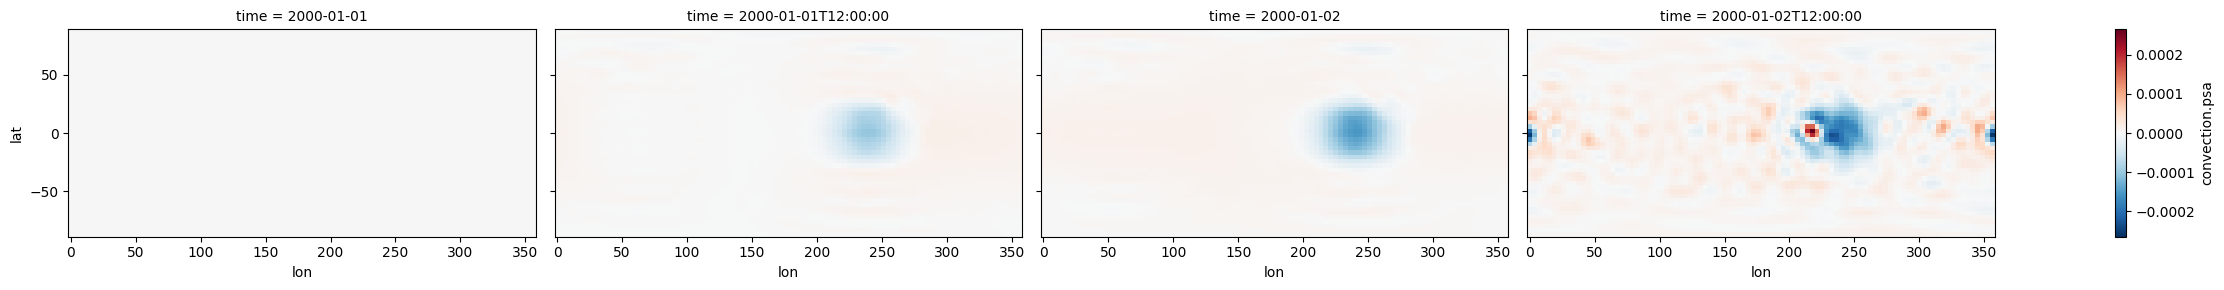

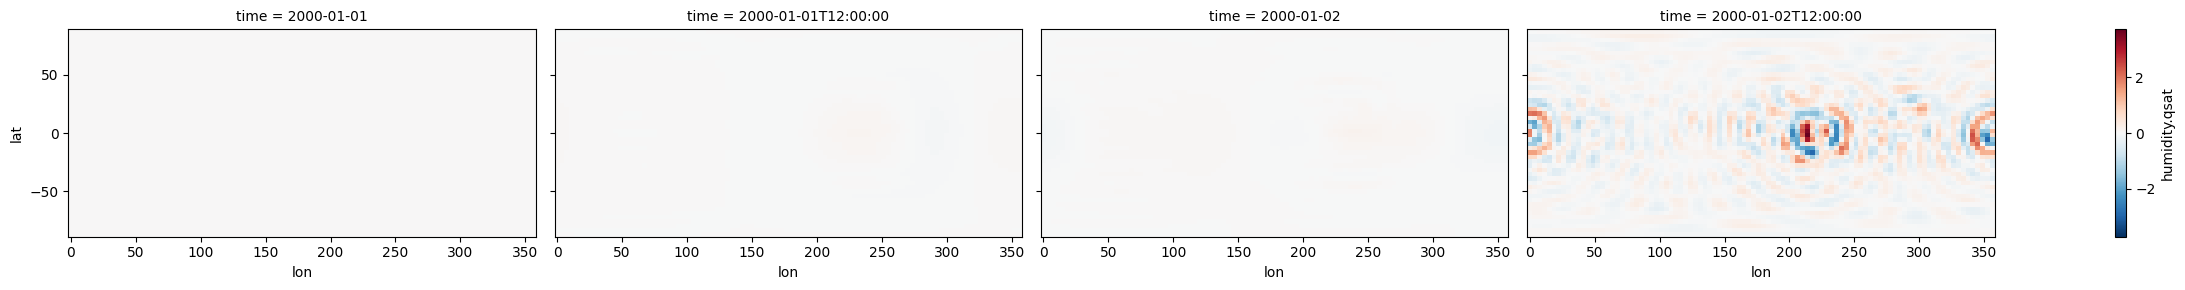

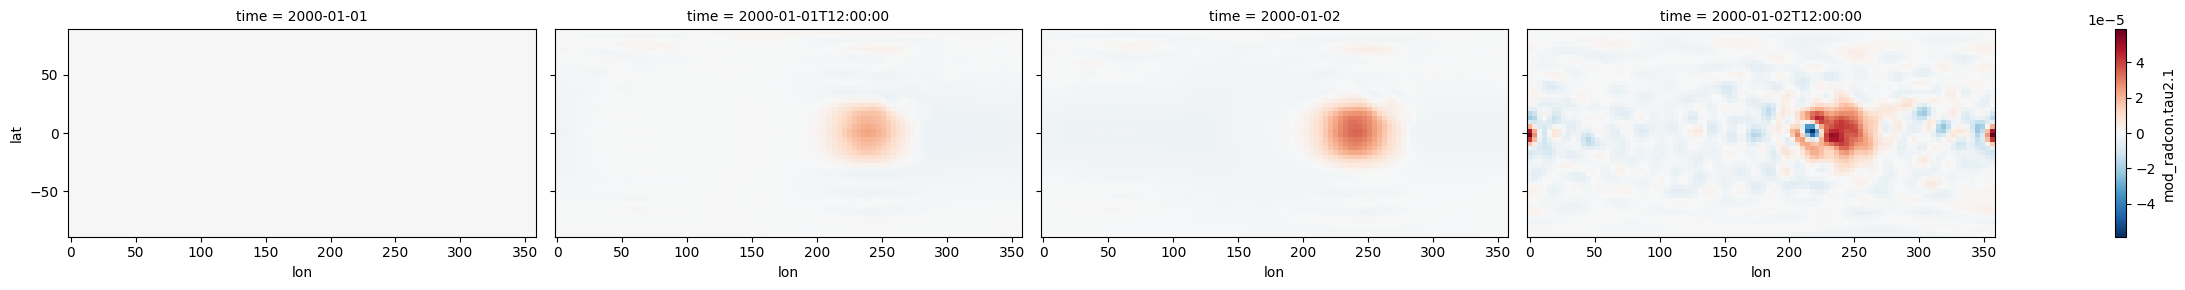

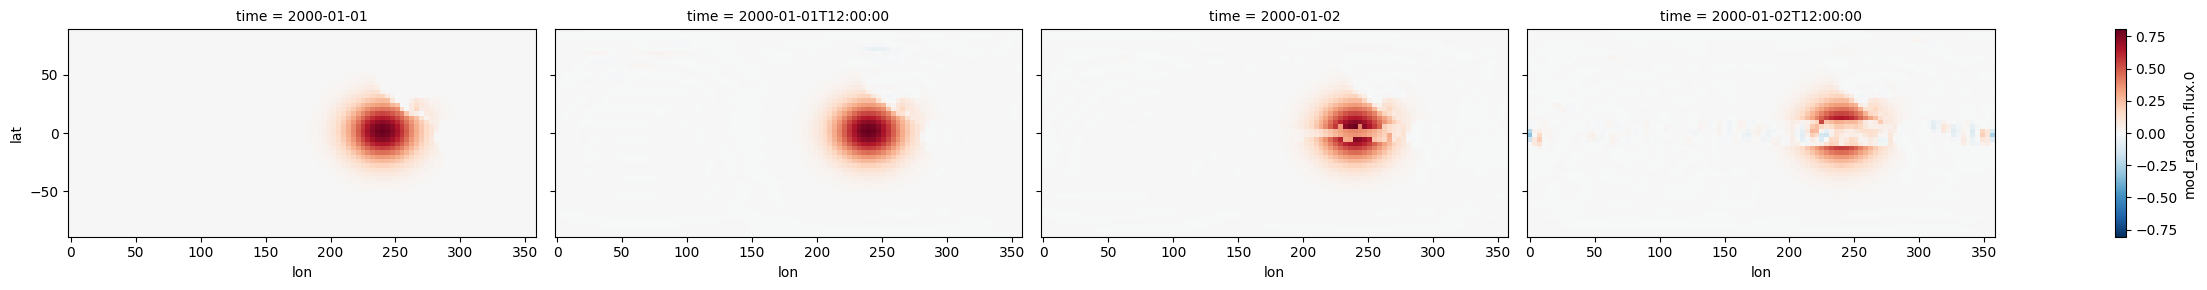

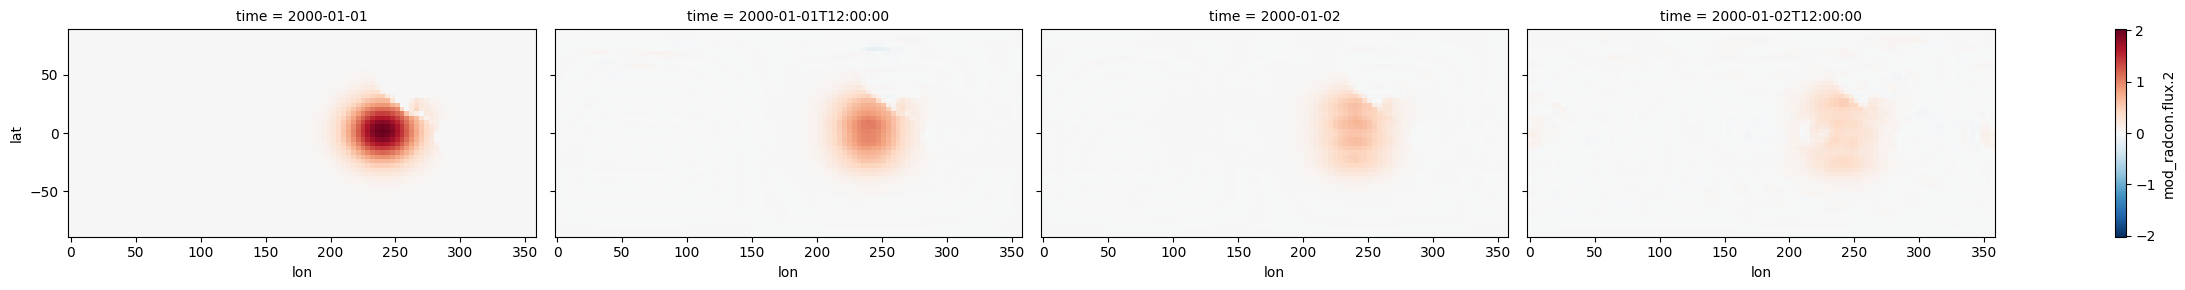

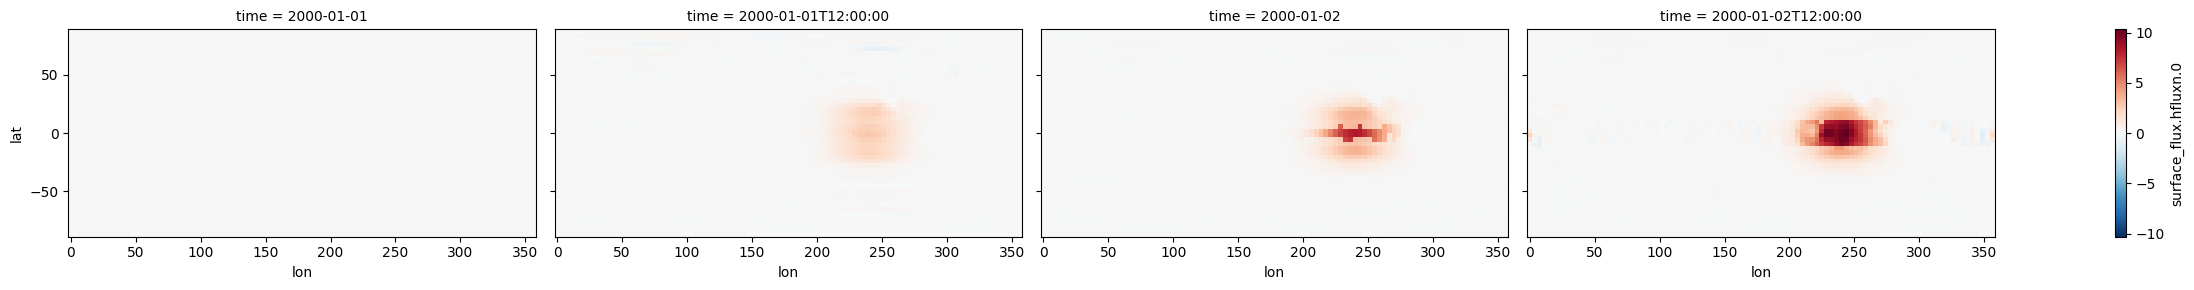

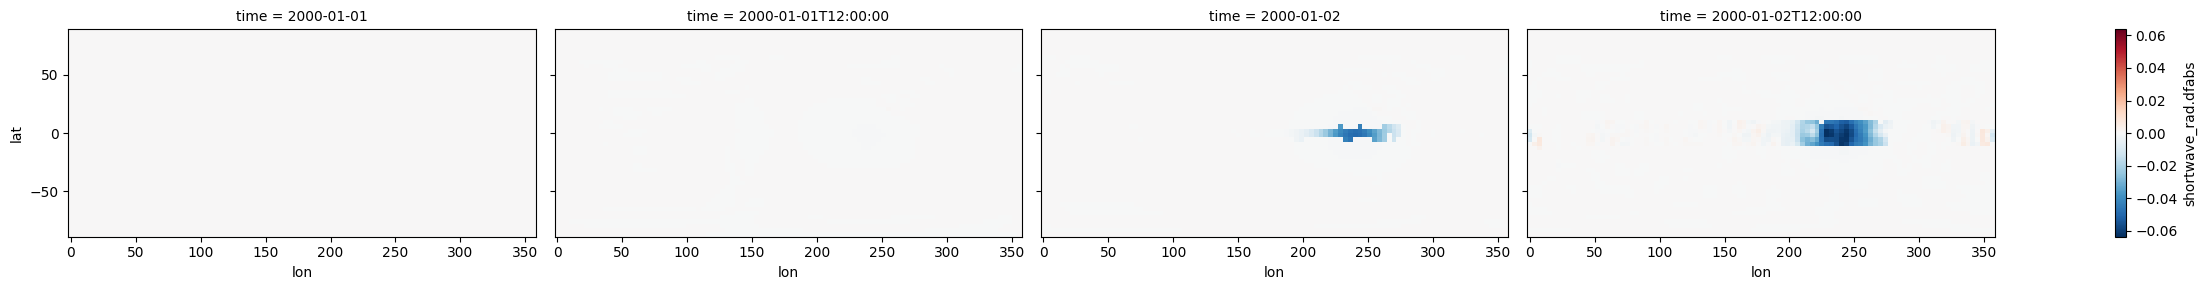

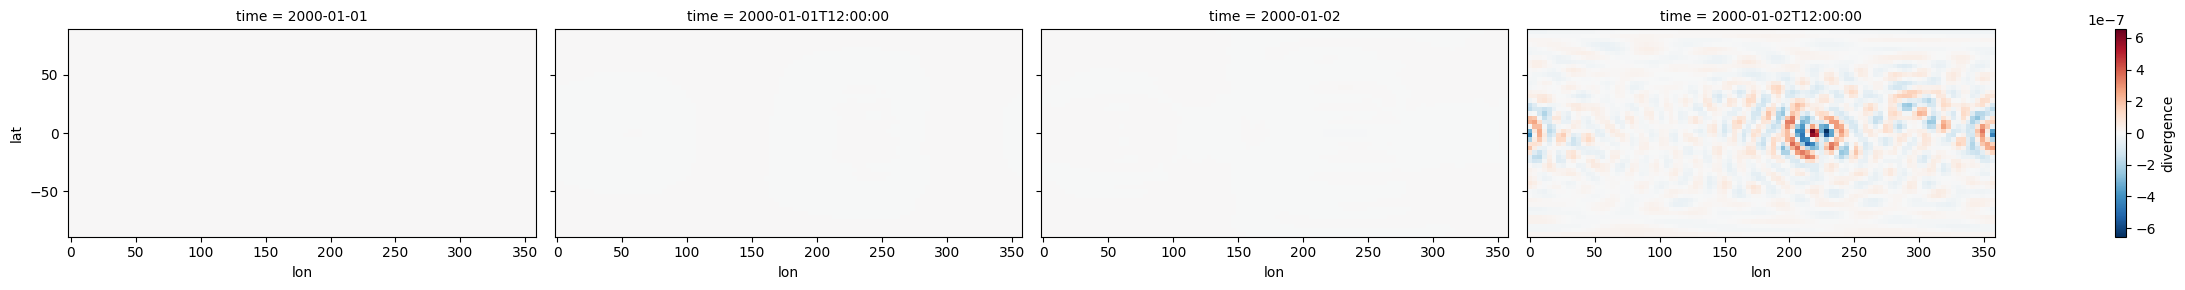

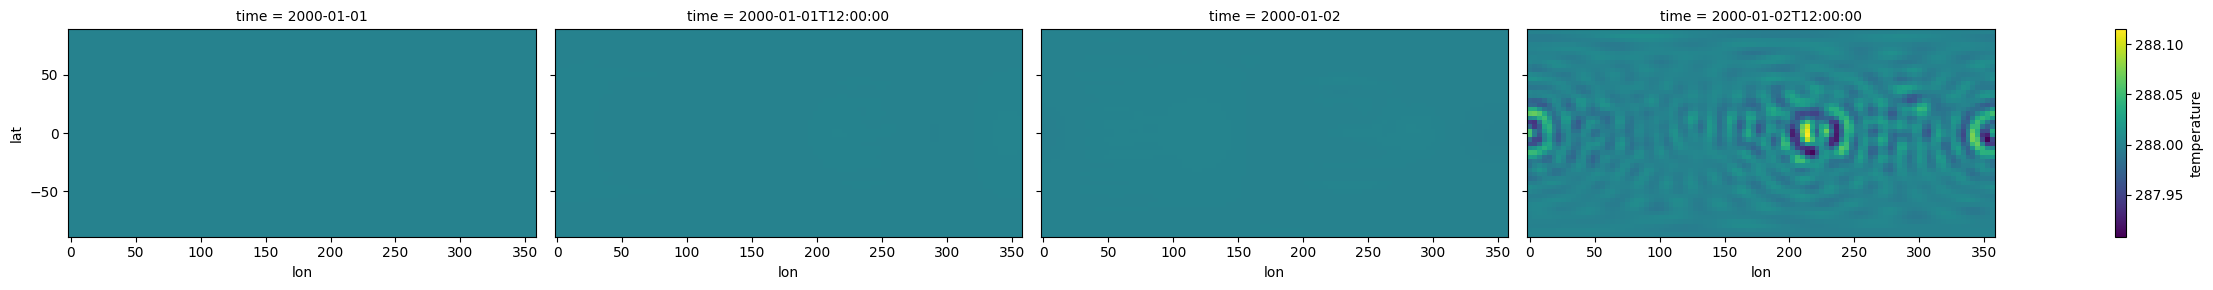

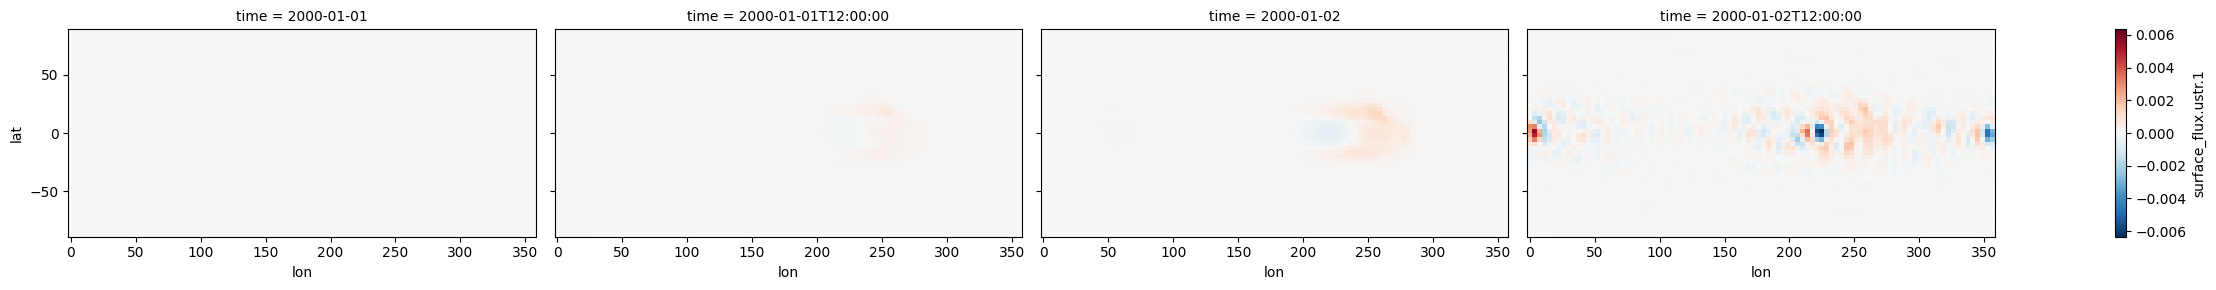

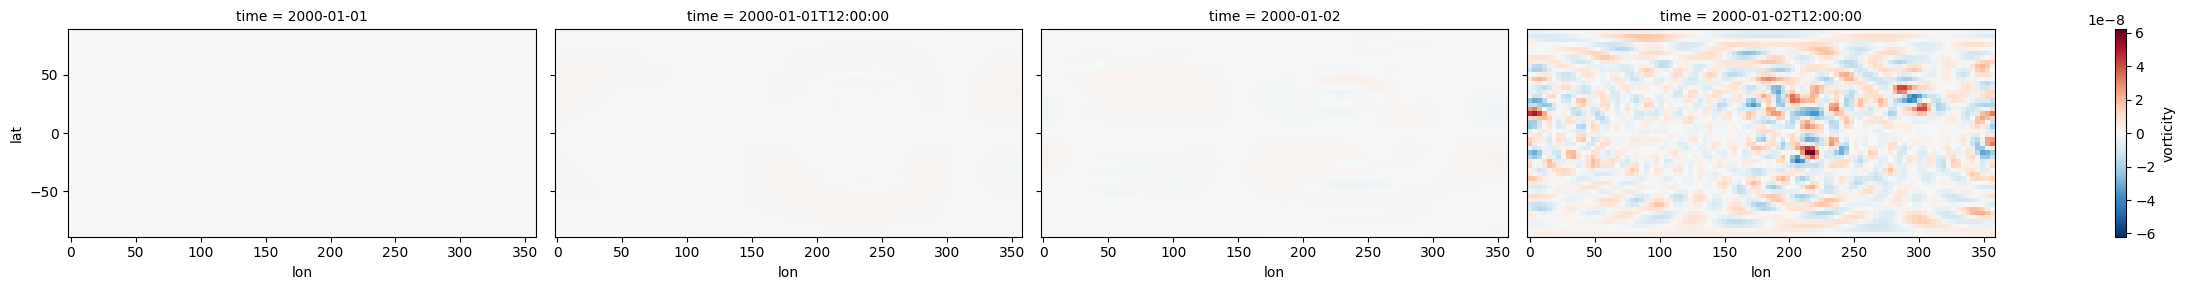

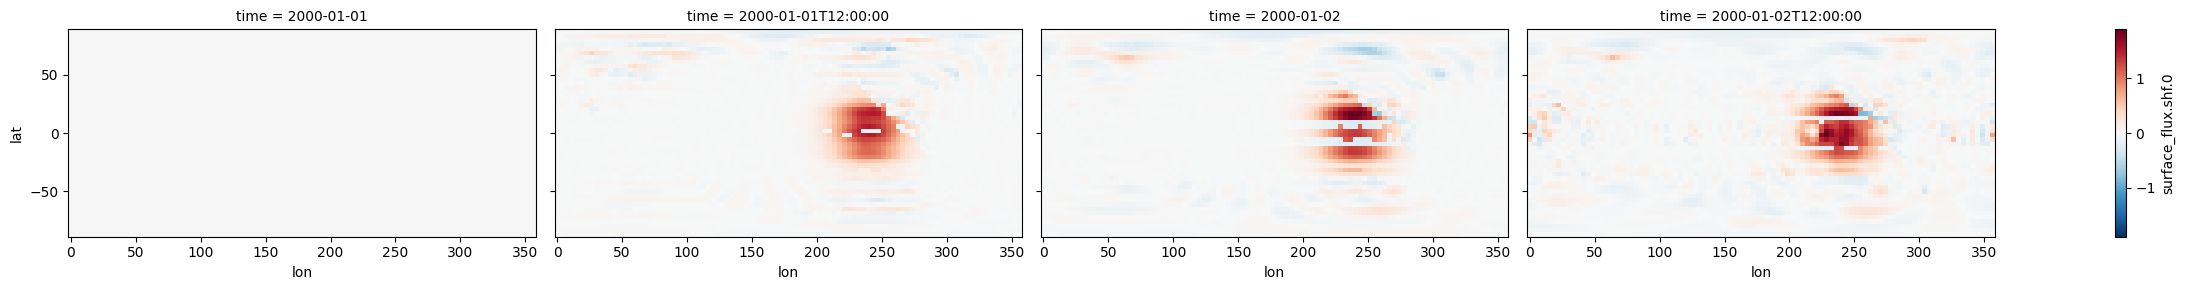

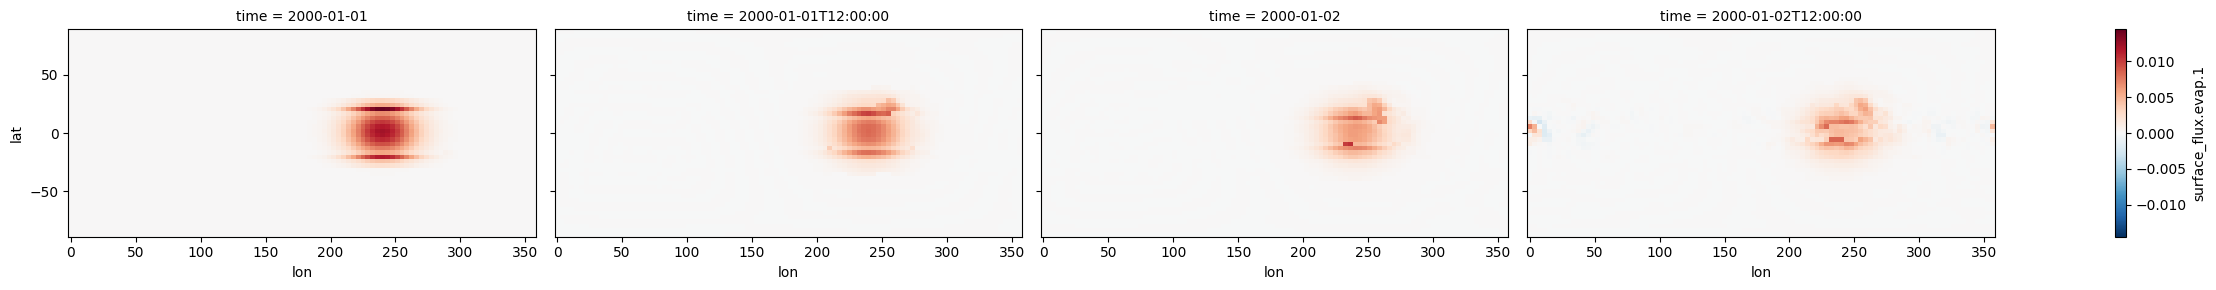

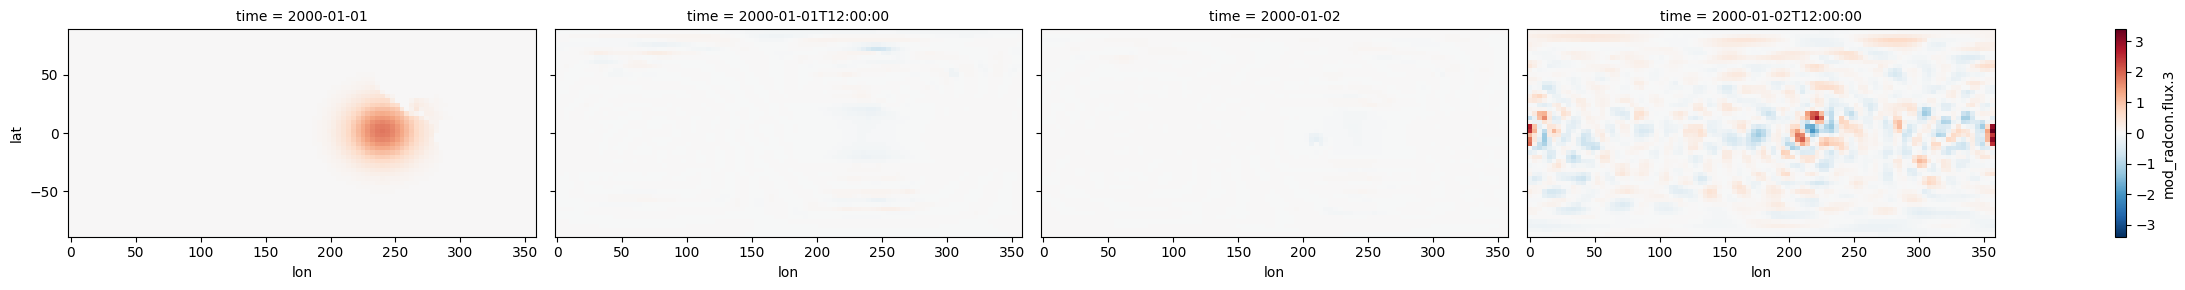

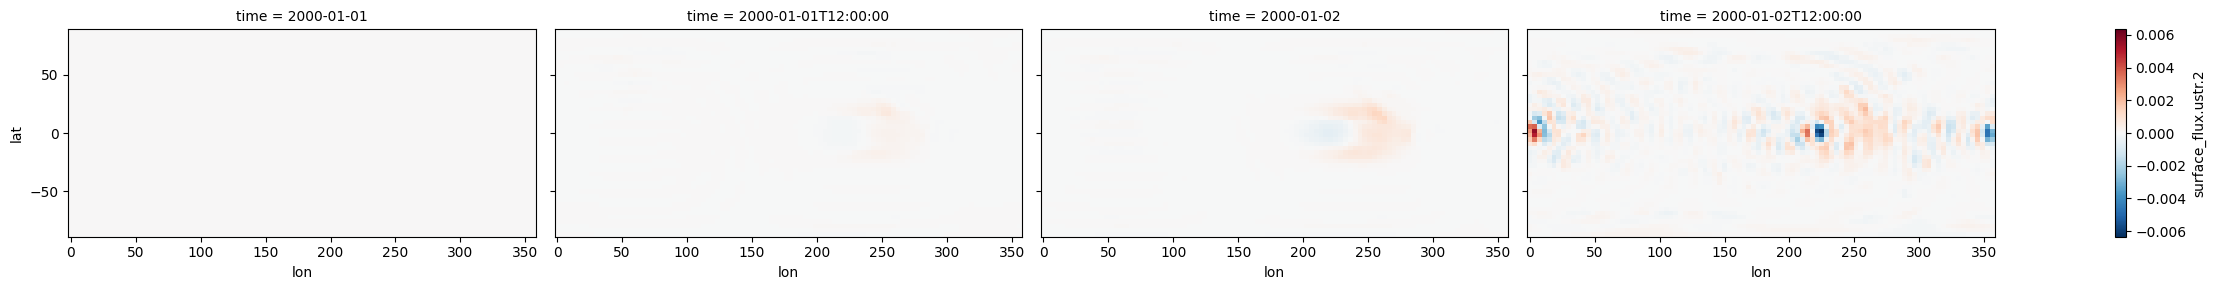

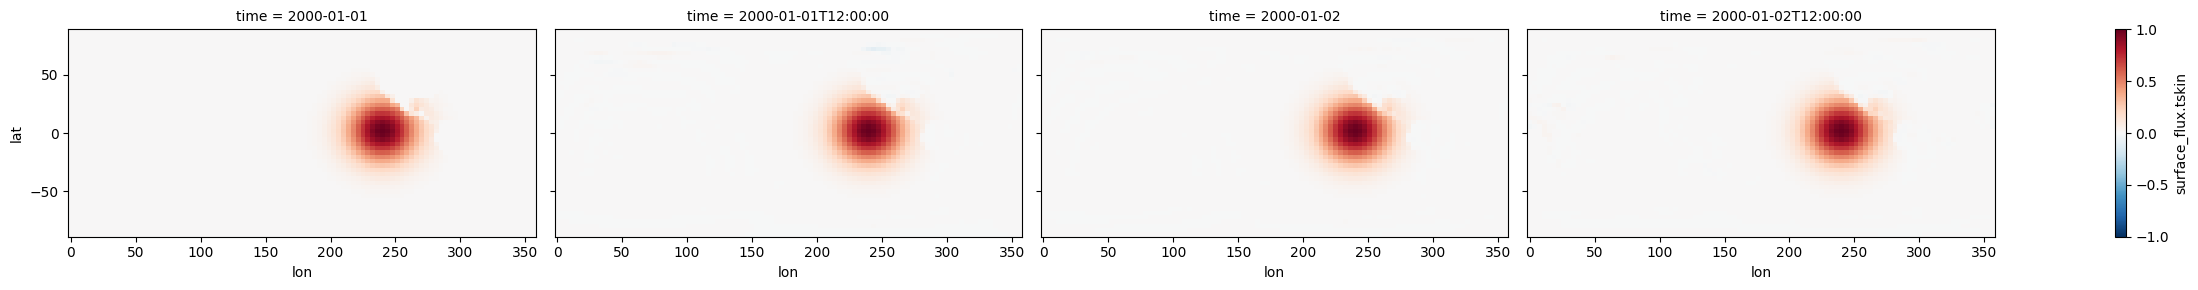

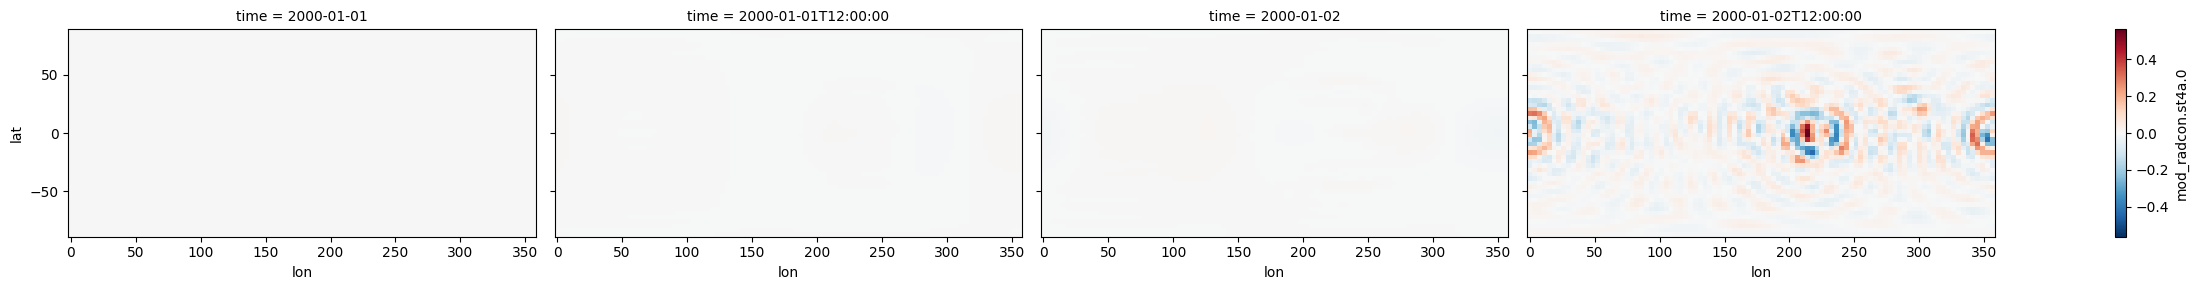

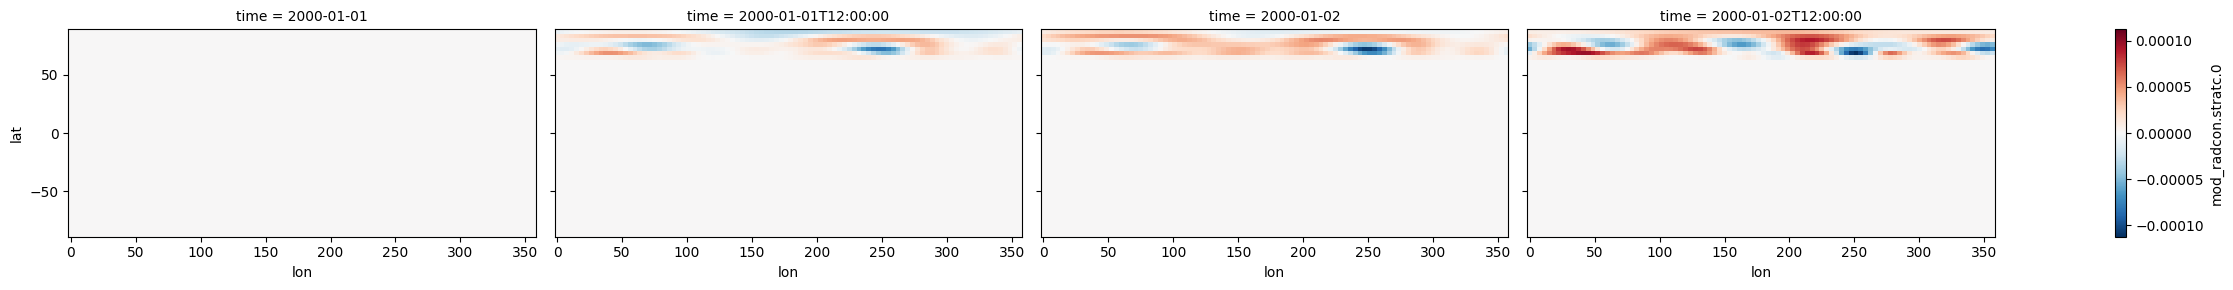

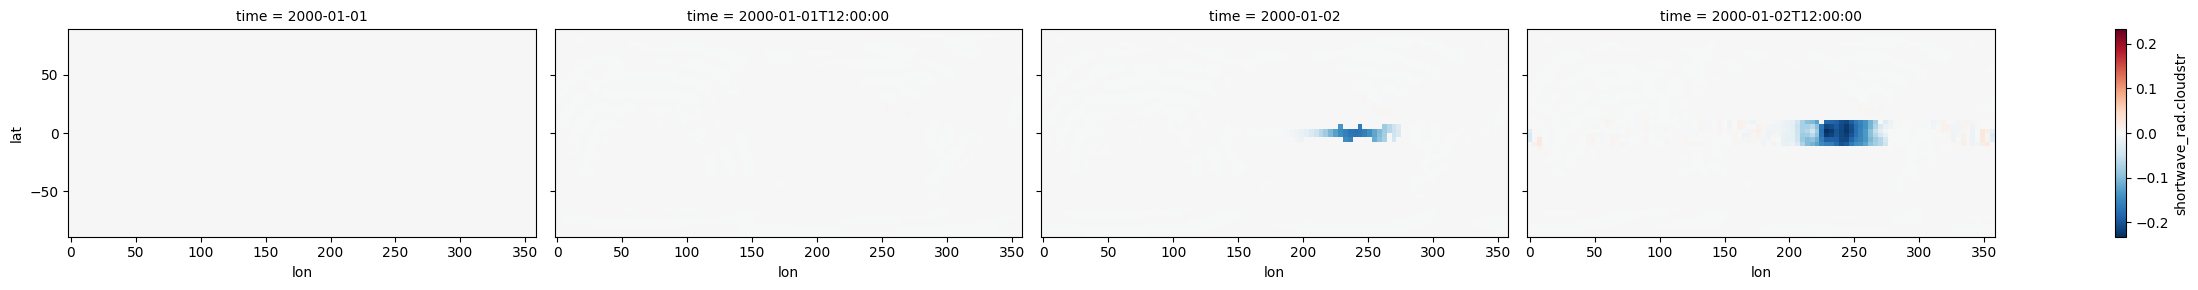

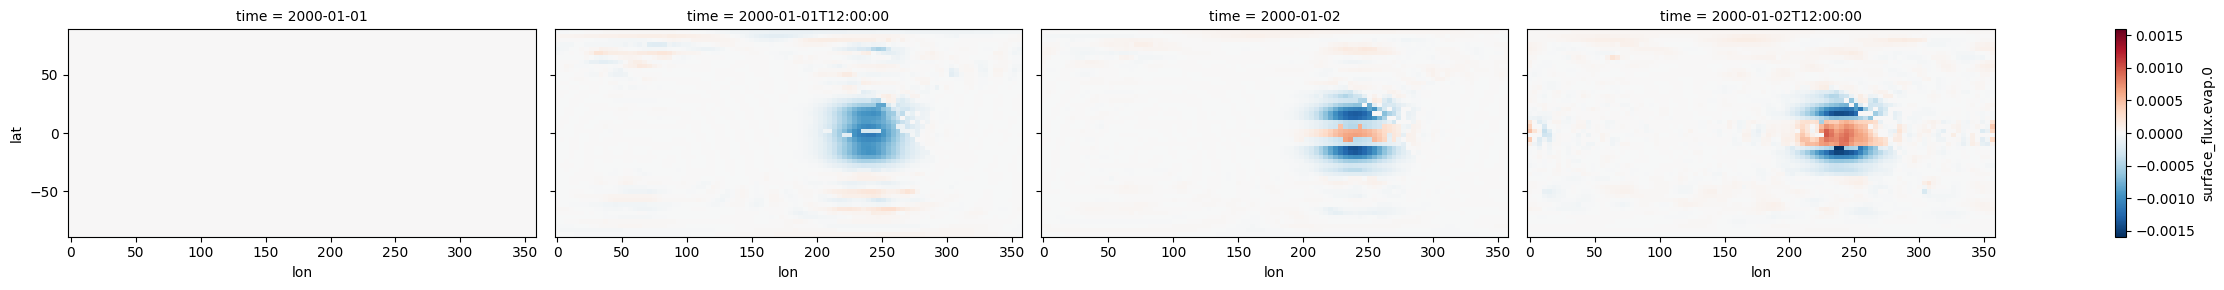

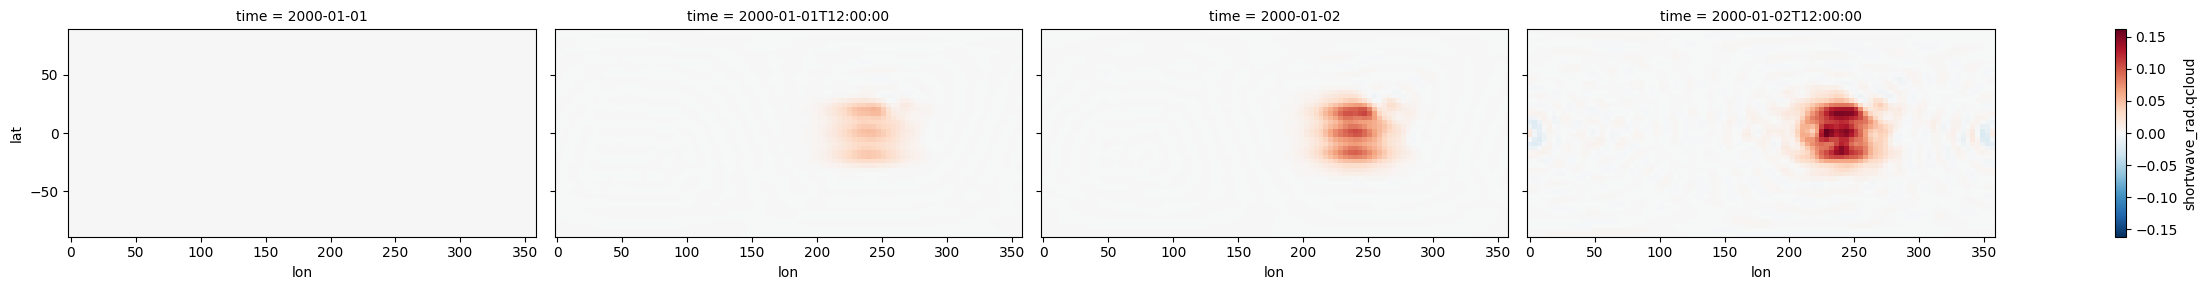

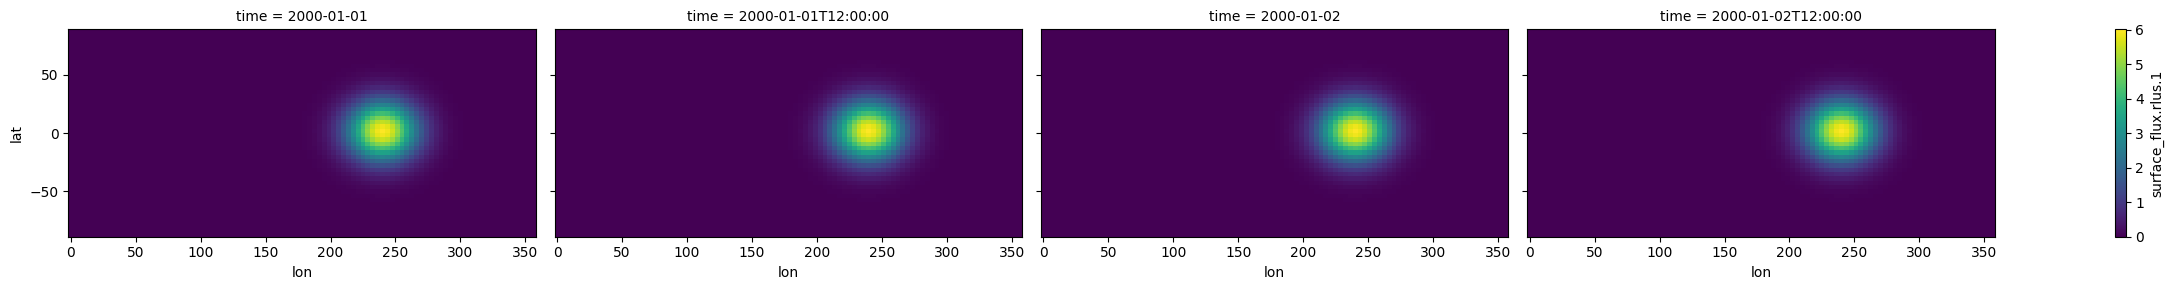

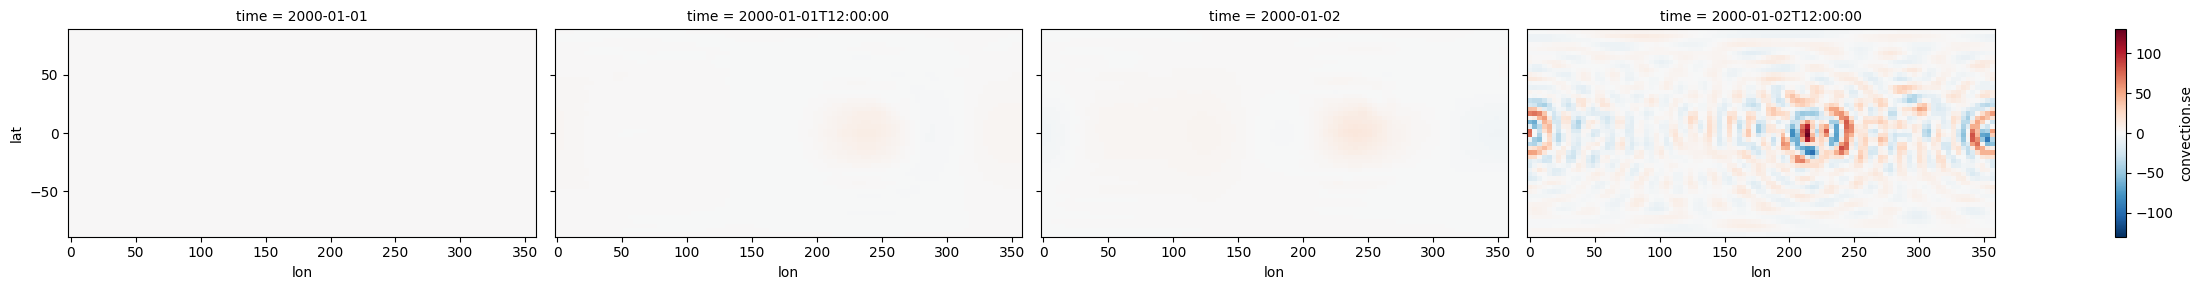

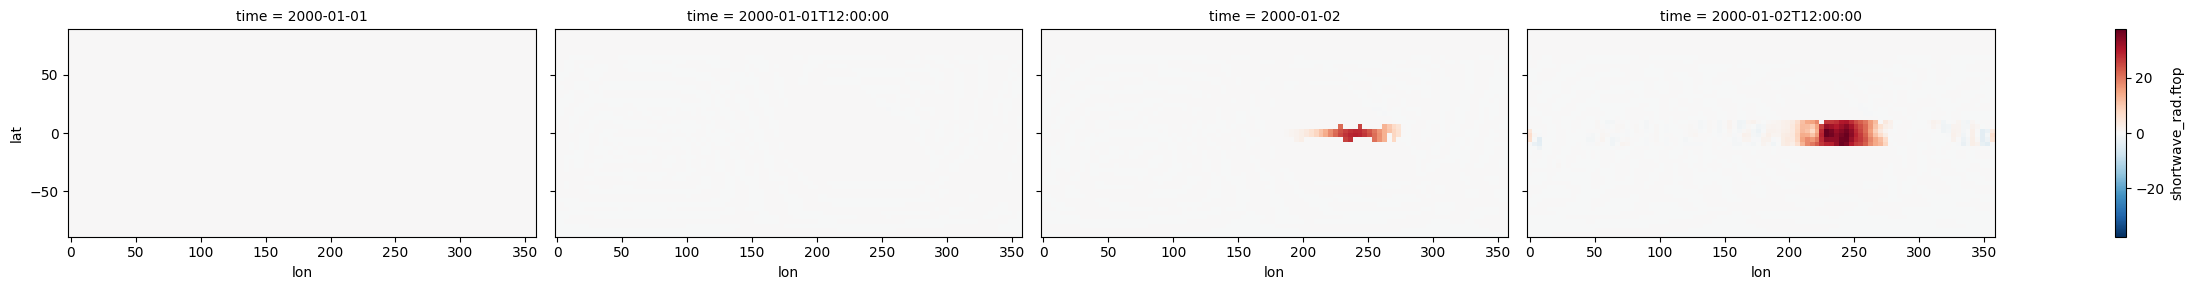

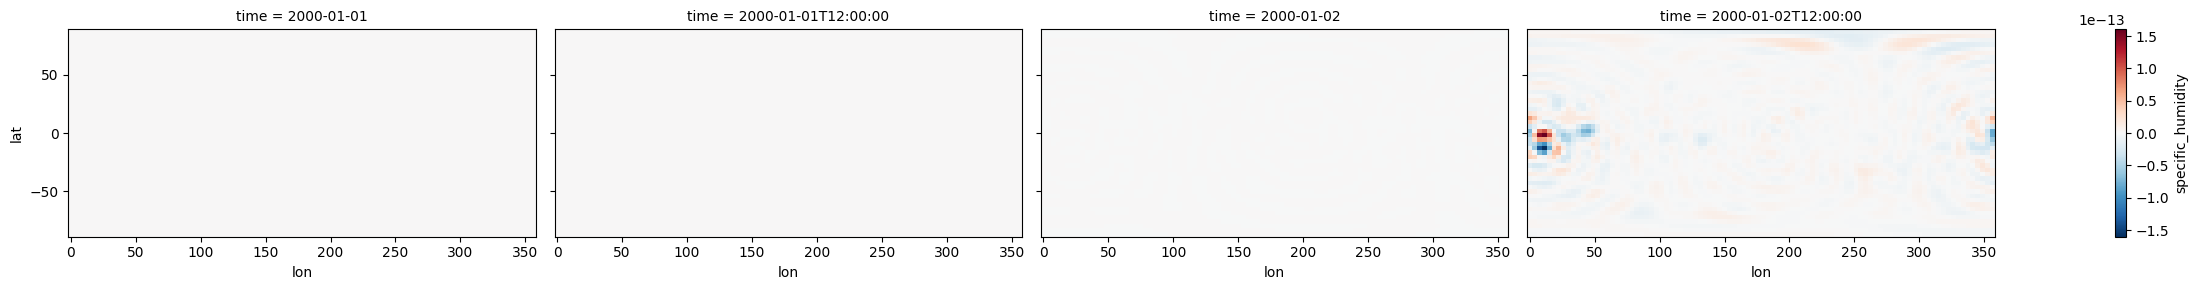

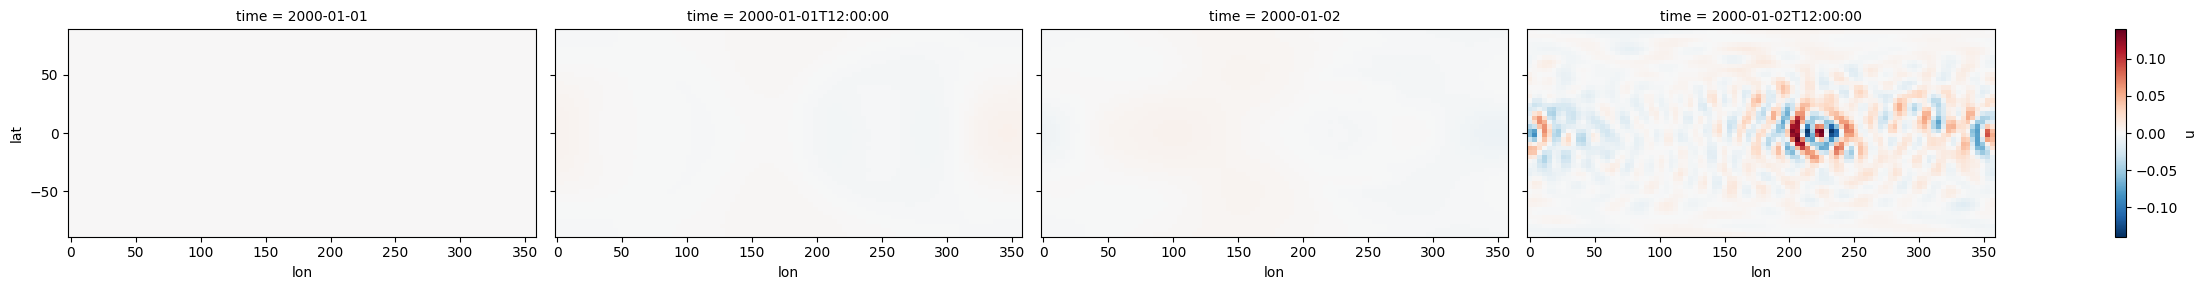

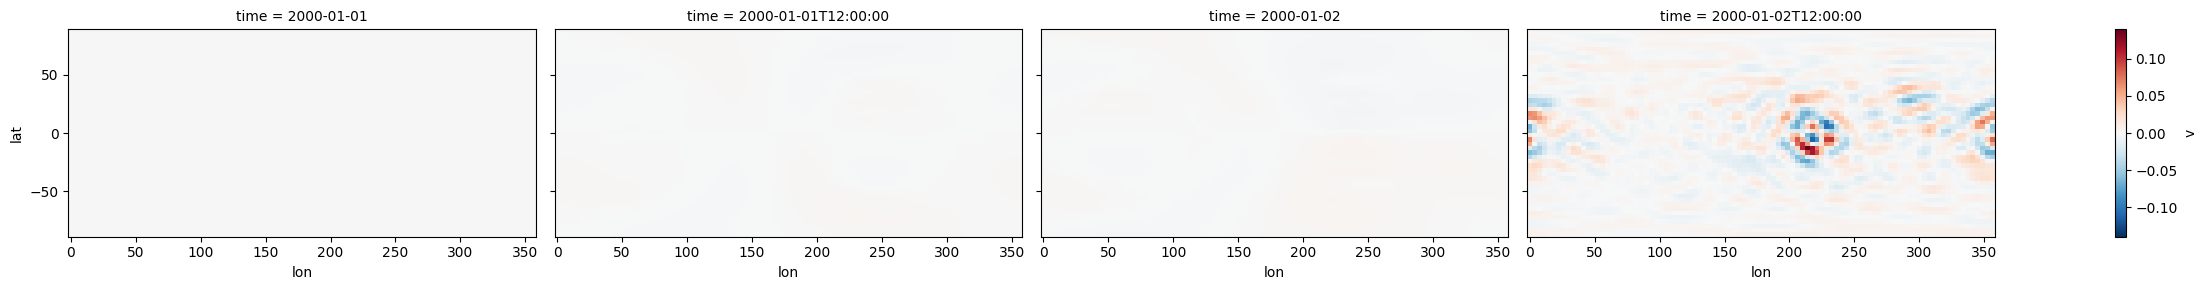

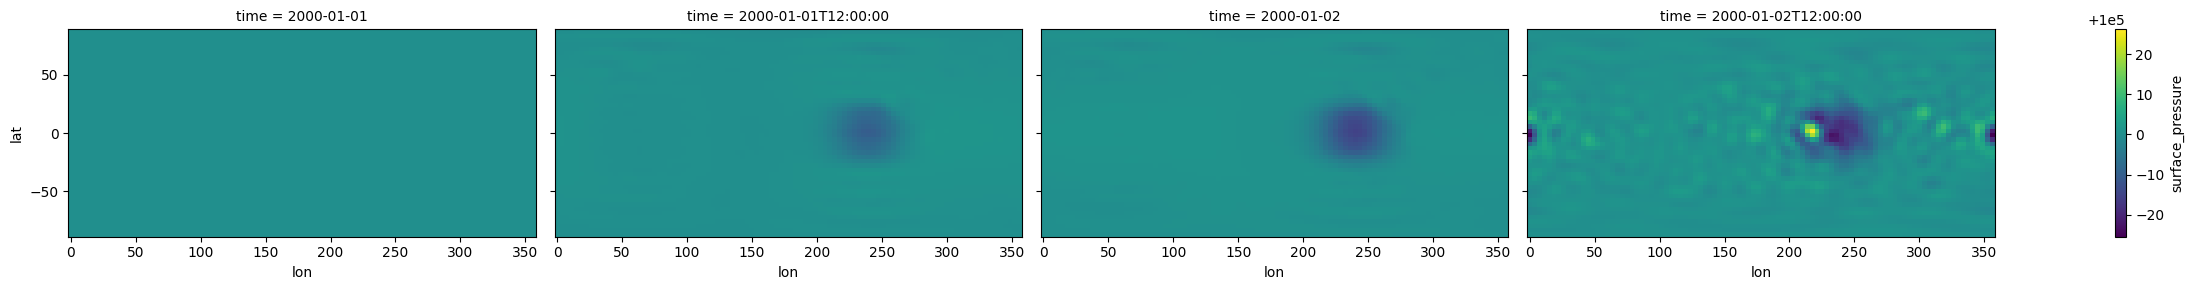

In [14]:
plot_ds = grad_ds.isel(level=-1).isel(time=slice(0, 4))
for v in list(plot_ds.data_vars):
    if v in ['mod_radcon.ablco2', 'convection.iptop', 'date.model_year', 'date.tyear', 'shortwave_rad.icltop']:
        continue
    data = plot_ds[v]
    if np.nanmax(data) == np.nanmin(data):
        print(f"gradient of {v} is {np.nanmax(data)}")
        continue
    if set(['lon', 'lat', 'time']).issubset(set(list(plot_ds[v].coords))):
        data.plot(x='lon', y='lat', size=3, aspect=2, col='time', col_wrap=4);
    else:
        continue
        data.plot(x='lon', y='lat', size=3, aspect=2);